# Climate-Related Development Finance (CRDF) Analysis

This notebook analyzes climate finance data from 2000-2023 with the following visualizations:

1. Climate Finance Over Time (Trend)
2. Top Recipient Countries (Distribution)
3. Finance by Region (Stacked Bar)
4. Adaptation vs Mitigation Balance
5. Distribution by Income Group (Equity)
6. Sector Allocation of Climate Finance
7. Provider → Recipient Network (Flows)
8. Project-Level Impact Proxy
9. Channel of Delivery Analysis

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Load the CRDF dataset
file_path = 'crdfdata.xlsx'

# First, check what sheets are available
xl_file = pd.ExcelFile(file_path)
print("Available sheets:", xl_file.sheet_names)

# Try reading the first sheet - the file might have headers in row 0
df = pd.read_excel(file_path, sheet_name=0, header=0)

# If empty, try reading without header to see what's there
if df.empty or len(df.columns) == 0:
    print("\nDataset appears empty. Trying to read without header to inspect...")
    df_temp = pd.read_excel(file_path, sheet_name=0, header=None, nrows=20)
    print("First 20 rows (no header):")
    print(df_temp)
    
    # Try to find the header row
    for i in range(min(10, len(df_temp))):
        row = df_temp.iloc[i]
        # Check if this row contains expected column names
        row_str = ' '.join([str(x).lower() for x in row.values if pd.notna(x)])
        if 'year' in row_str and 'recipient' in row_str:
            print(f"\nFound potential header row at index {i}")
            df = pd.read_excel(file_path, sheet_name=0, header=i)
            break

# If still empty, try other sheets
if (df.empty or len(df.columns) == 0) and len(xl_file.sheet_names) > 1:
    print(f"\nTrying other sheets...")
    for sheet in xl_file.sheet_names[1:]:
        print(f"Trying sheet: {sheet}")
        df = pd.read_excel(file_path, sheet_name=sheet, header=0)
        if not df.empty and len(df.columns) > 0:
            print(f"Successfully loaded from sheet: {sheet}")
            break

print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names:")
if len(df.columns) > 0:
    print(df.columns.tolist()[:20])  # Show first 20 columns
    print(f"\nFirst few rows:")
    print(df.head())
else:
    print("No columns found. Please check the Excel file structure.")

Available sheets: ['All']

Dataset shape: (222723, 38)

Column names:
['Year', 'Provider Type', 'Provider', 'Provider (detailed)', 'Provider Code', 'Agency Code', 'Extending Agency', 'CRS Identification N°', 'Donor project N°', 'Recipient', 'Recipient Code', 'Recipient Region', 'Recipient Income Group (OECD Classification)', 'Concessionality', 'Climate objective (applies to Rio-marked data only) or climate component', 'Adaptation objective (applies to Rio-marked data only)', 'Mitigation objective (applies to Rio-marked data only)', 'Adaptation-related development finance (includes overlap) - Commitment - Current USD thousand', 'Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand', 'Mitigation-related development finance (includes overlap) - Commitment - Current USD thousand']

First few rows:
   Year Provider Type   Provider Provider (detailed)  Provider Code  \
0  2000    DAC member    Finland             Finland             18   
1  2000    DAC 

In [3]:
target_sector = "III.1. Agriculture, Forestry, Fishing"
target_country = "Mexico"

# Check required columns
required_cols = ["Sector", "Recipient"]
missing = [col for col in required_cols if col not in df.columns]

if missing:
    print(f"Missing columns: {missing}")
else:
    # Filter for Mexico
    df_mexico = df[df["Recipient"].astype(str).str.strip() == target_country]

    # Count rows in target sector
    sector_count = (
        df_mexico["Sector"]
        .astype(str)
        .str.strip()
        .eq(target_sector)
        .sum()
    )

    print(
        f"Number of rows for sector '{target_sector}' "
        f"with Recipient = {target_country}: {sector_count}"
    )

Number of rows for sector 'III.1. Agriculture, Forestry, Fishing' with Recipient = Mexico: 217


In [5]:
# Filter data to Mexico only
if 'Recipient' in df.columns:
    # Check what Mexico is called in the dataset
    mexico_variants = ['Mexico', 'México', 'MEXICO']
    mexico_found = False
    
    for variant in mexico_variants:
        if variant in df['Recipient'].values:
            print(f"Found '{variant}' in Recipient column")
            df = df[df['Recipient'].astype(str).str.strip() == variant].copy()
            mexico_found = True
            break
    
    if not mexico_found:
        # Try case-insensitive search
        mexico_mask = df['Recipient'].astype(str).str.strip().str.lower().str.contains('mexico', na=False)
        if mexico_mask.any():
            mexico_name = df.loc[mexico_mask, 'Recipient'].iloc[0]
            print(f"Found Mexico as: '{mexico_name}'")
            df = df[df['Recipient'].astype(str).str.strip() == mexico_name].copy()
            mexico_found = True
    
    if mexico_found:
        print(f"\nFiltered dataset shape: {df.shape}")
        print(f"Filtered to: {df['Recipient'].unique()}")
    else:
        print("Warning: Mexico not found in Recipient column. Showing unique recipients:")
        print(df['Recipient'].unique()[:20])
else:
    print("Column 'Recipient' not found in dataset.")

Found 'Mexico' in Recipient column

Filtered dataset shape: (1759, 38)
Filtered to: ['Mexico']


In [6]:
# Explore the data structure
print("Data info:")
print(df.info())
print("\n\nMissing values:")
print(df.isnull().sum())
print("\n\nSample data:")
df.head(10)

Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 1759 entries, 504 to 221232
Data columns (total 38 columns):
 #   Column                                                                                         Non-Null Count  Dtype  
---  ------                                                                                         --------------  -----  
 0   Year                                                                                           1759 non-null   int64  
 1   Provider Type                                                                                  1759 non-null   object 
 2   Provider                                                                                       1759 non-null   object 
 3   Provider (detailed)                                                                            1759 non-null   object 
 4   Provider Code                                                                                  1759 non-null   int64  
 5   Agency Cod

,Year,Provider Type,Provider,Provider (detailed),Provider Code,Agency Code,Extending Agency,CRS Identification N°,Donor project N°,Recipient,Recipient Code,Recipient Region,Recipient Income Group (OECD Classification),Concessionality,Climate objective (applies to Rio-marked data only) or climate component,Adaptation objective (applies to Rio-marked data only),Mitigation objective (applies to Rio-marked data only),Adaptation-related development finance (includes overlap) - Commitment - Current USD thousand,Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand,Mitigation-related development finance (includes overlap) - Commitment - Current USD thousand,Mitigation-related development finance (includes overlap) - Commitment - 2023 USD thousand,Overlap - Commitment - Current USD thousand,Overlap - Commitment - 2023 USD thousand,Climate-related development finance - Commitment - Current USD thousand,Climate-related development finance - Commitment - 2023 USD thousand,Channel of Delivery Code,Channel of Delivery,Purpose Code,Sector,Sub-sector,Development Cooperation Modality,Financial Instrument,Type of Finance,Project Title,Description,Coal-related Financing,"Share of the underlying commitment, % (when available)",Gender
504,2000,DAC member,Spain,Spain,50,5.0,Ministry of Foreign Affairs and Co-operation,2000002713z,100611200000,Mexico,358,Caribbean & Central America,UMICs,Concessional and developmental,Significant,Not targeted/Not screened,Significant,0.0,0.0,82.251053,158.095888,0.0,0.0,82.251053,158.095888,NaN,NaN,41030.0,IV.1. General Environment Protection,Biodiversity,NaN,Grant,110.0,ASSISTANCE TECHNIQUE PROJET BISCAYE D'ARAUCARI...,NaN,0.0,1.0,NaN
505,2000,DAC member,Spain,Spain,50,15.0,Autonomous Governments,2000002688z,100303200000,Mexico,358,Caribbean & Central America,UMICs,Concessional and developmental,Significant,Not targeted/Not screened,Significant,0.0,0.0,15.231677,29.277016,0.0,0.0,15.231677,29.277016,NaN,NaN,41010.0,IV.1. General Environment Protection,Environmental policy and administrative manage...,NaN,Grant,110.0,PROJET ARAUCARIA - VIZCAINO,NaN,0.0,1.0,NaN
993,2001,DAC member,Germany,Germany,5,52.0,Deutsche Gesellschaft für Internationale Zusam...,2001006659z,200122788,Mexico,358,Caribbean & Central America,UMICs,Concessional and developmental,Significant,Not targeted/Not screened,Significant,0.0,0.0,2289.091886,4183.860677,0.0,0.0,2289.091886,4183.860677,NaN,NaN,41010.0,IV.1. General Environment Protection,Environmental policy and administrative manage...,NaN,Grant,110.0,EFFICIENCY IN THE PRIVATE SECTOR,NaN,0.0,1.0,Significant
1244,2001,DAC member,Germany,Germany,5,52.0,Deutsche Gesellschaft für Internationale Zusam...,2001008337z,199222456,Mexico,358,Caribbean & Central America,UMICs,Concessional and developmental,Significant,Not targeted/Not screened,Significant,0.0,0.0,0.411965,0.752964,0.0,0.0,0.411965,0.752964,NaN,NaN,41010.0,IV.1. General Environment Protection,Environmental policy and administrative manage...,NaN,Grant,110.0,ENVIRONMENTAL POLICY AND ADMIN. MGMT,NaN,0.0,1.0,Significant
1889,2003,DAC member,United States,United States,302,99.0,Miscellaneous,2003007263z,03IFW00002,Mexico,358,Caribbean & Central America,UMICs,Concessional and developmental,Principal,Not targeted/Not screened,Principal,0.0,0.0,30.000000,47.635148,0.0,0.0,30.000000,47.635148,NaN,NaN,41030.0,IV.1. General Environment Protection,Biodiversity,NaN,Grant,110.0,22ND RESERVA PROGRAM,"MULTINATIONAL SPECIES CONSERVATION FUND, U.S. ...",0.0,1.0,NaN
1890,2003,DAC member,United States,United States,302,99.0,Miscellaneous,2003007264z,03IFW00151,Mexico,358,Caribbean & Central America,UMICs,Concessional and developmental,Principal,Not targeted/Not screened,Principal,0.0,0.0,30.000000,47.635148,0.0,0.0,30.000000,47.635148,NaN,NaN,41030.0,IV.1. General Environment Protection,Biodiversity,NaN,Grant,110.0,THIRD NATIONAL COURSE FOR ECOLOGICAL RESERVE R...,"MULTINATIONAL SPECIES CONSERVATION FUND, U.S. ...",0.

In [7]:
# Filter data to Mexico only
target_recipient = "Mexico"

if 'Recipient' not in df.columns:
    print("Column 'Recipient' not found in df.")
else:
    # Check unique recipient values to see if Mexico exists (case-insensitive)
    unique_recipients = df['Recipient'].astype(str).str.strip().unique()
    mexico_variants = [r for r in unique_recipients if 'mexico' in r.lower()]
    
    if mexico_variants:
        print(f"Found Mexico recipient variants: {mexico_variants}")
        # Filter to Mexico (case-insensitive)
        df = df[df['Recipient'].astype(str).str.strip().str.lower() == 'mexico'].copy()
        print(f"\nFiltered dataset shape: {df.shape}")
        print(f"Number of rows for Mexico: {len(df)}")
    else:
        print(f"Warning: 'Mexico' not found in Recipient column.")
        print(f"Sample recipients: {list(unique_recipients[:20])}")

Found Mexico recipient variants: ['Mexico']

Filtered dataset shape: (1759, 38)
Number of rows for Mexico: 1759


## 1. Climate Finance Over Time (Trend)

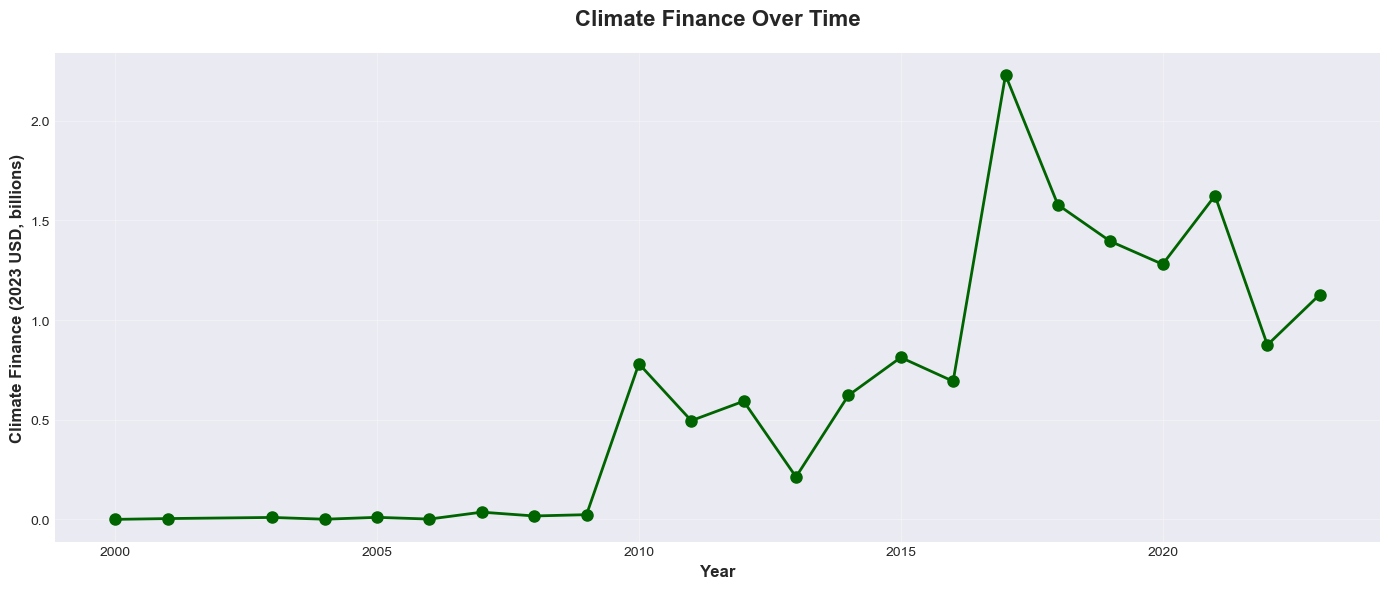


Climate Finance by Year (2023 USD, billions):
Year
2000    0.00
2001    0.00
2003    0.01
2004    0.00
2005    0.01
2006    0.00
2007    0.04
2008    0.02
2009    0.02
2010    0.78
2011    0.50
2012    0.59
2013    0.21
2014    0.62
2015    0.81
2016    0.69
2017    2.23
2018    1.58
2019    1.40
2020    1.28
2021    1.62
2022    0.88
2023    1.13
Name: Climate-related development finance - Commitment - 2023 USD thousand, dtype: float64


In [8]:
# Clean and prepare the data
# Convert Year to numeric if needed
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Convert climate finance column to numeric
climate_finance_col = 'Climate-related development finance - Commitment - 2023 USD thousand'
df[climate_finance_col] = pd.to_numeric(df[climate_finance_col], errors='coerce')

# Aggregate by year
finance_by_year = df.groupby('Year')[climate_finance_col].sum().sort_index()

# Create line chart
plt.figure(figsize=(14, 6))
plt.plot(finance_by_year.index, finance_by_year.values / 1e6, marker='o', linewidth=2, markersize=8, color='darkgreen')
plt.title('Climate Finance Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nClimate Finance by Year (2023 USD, billions):")
print((finance_by_year / 1e6).round(2))

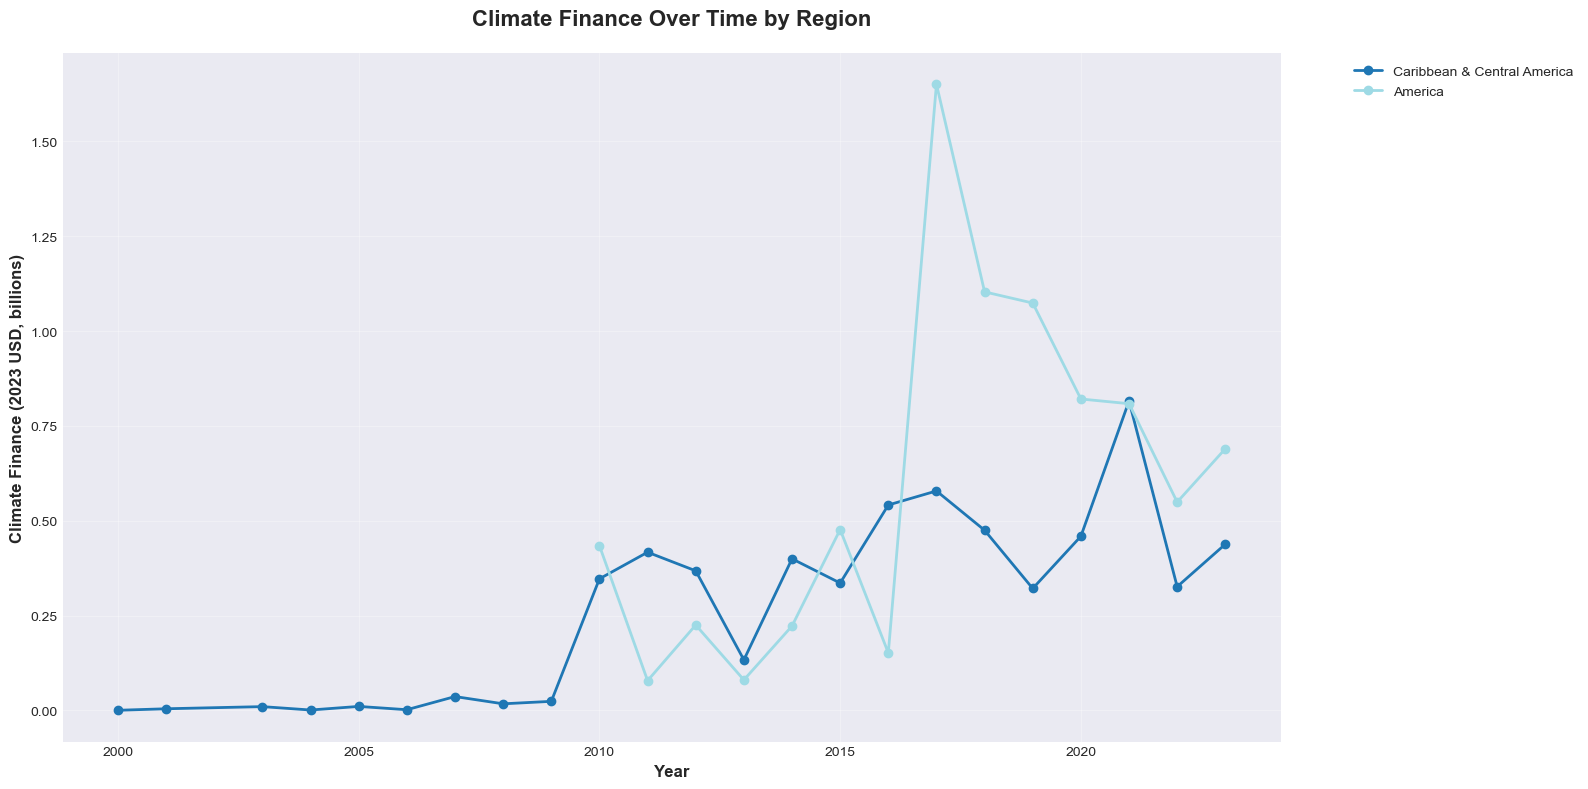

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Optional: Breakdown by Region
if 'Recipient Region' in df.columns:

    finance_by_year_region = (
        df.groupby(['Year', 'Recipient Region'])[climate_finance_col]
        .sum()
        .reset_index()
    )

    plt.figure(figsize=(16, 8))

    regions = finance_by_year_region['Recipient Region'].unique()

    # Choose a good categorical colormap
    cmap = plt.get_cmap('tab20')  # supports up to 20 distinct colors
    colors = cmap(np.linspace(0, 1, len(regions)))

    for i, region in enumerate(regions):
        region_data = finance_by_year_region[
            finance_by_year_region['Recipient Region'] == region
        ]

        plt.plot(
            region_data['Year'],
            region_data[climate_finance_col] / 1e6,
            marker='o',
            linewidth=2,
            markersize=6,
            label=region,
            color=colors[i]
        )

    plt.title(
        'Climate Finance Over Time by Region',
        fontsize=16,
        fontweight='bold',
        pad=20
    )
    plt.xlabel('Year', fontsize=12, fontweight='bold')
    plt.ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

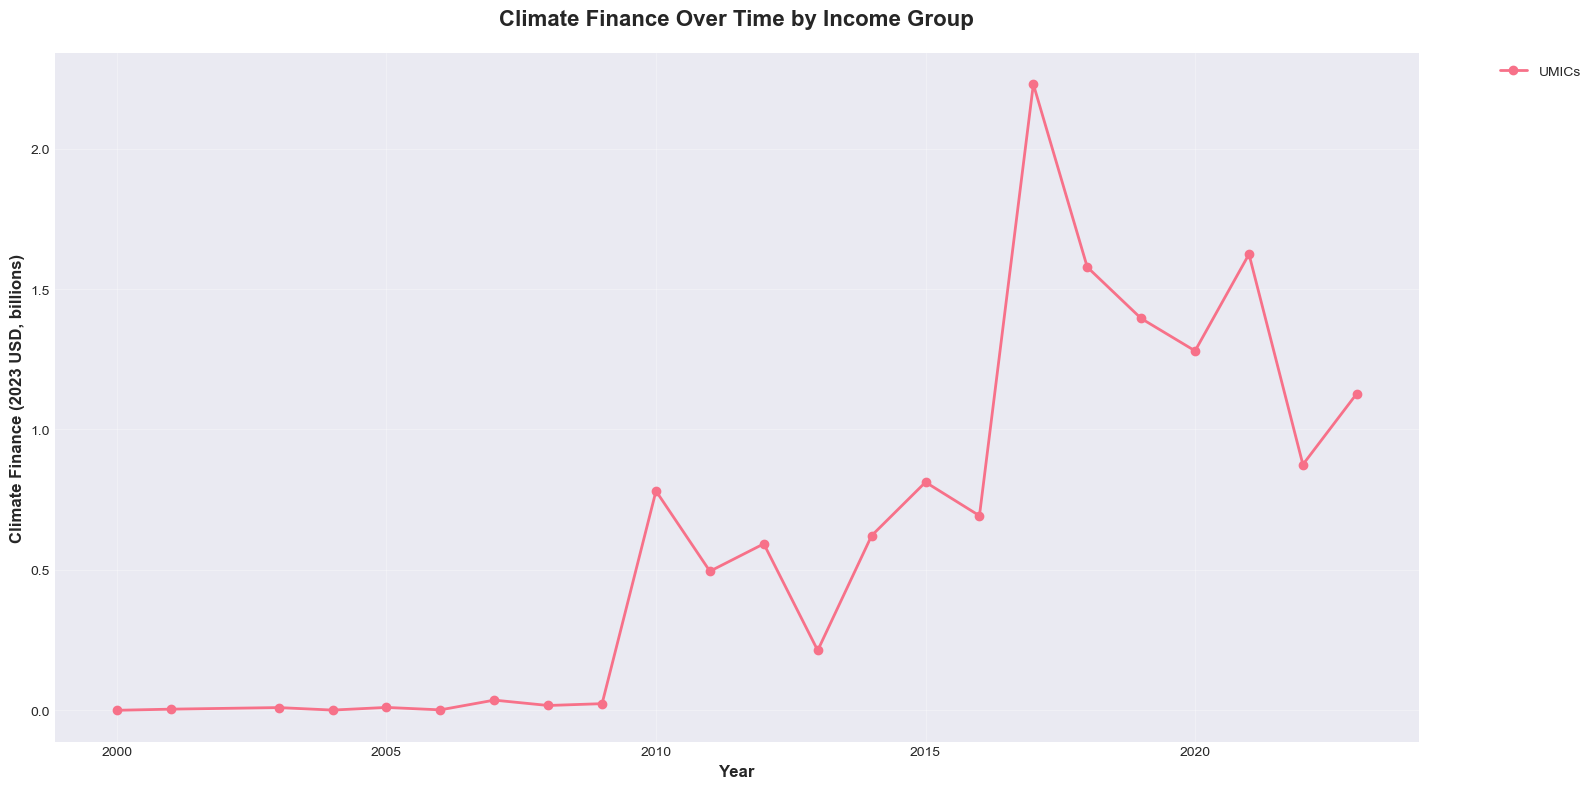

In [10]:
# Optional: Breakdown by Income Group
if 'Recipient Income Group (OECD Classification)' in df.columns:
    finance_by_year_income = df.groupby(['Year', 'Recipient Income Group (OECD Classification)'])[climate_finance_col].sum().reset_index()
    
    plt.figure(figsize=(16, 8))
    for income in finance_by_year_income['Recipient Income Group (OECD Classification)'].unique():
        income_data = finance_by_year_income[finance_by_year_income['Recipient Income Group (OECD Classification)'] == income]
        plt.plot(income_data['Year'], income_data[climate_finance_col] / 1e6, 
                marker='o', linewidth=2, label=income, markersize=6)
    
    plt.title('Climate Finance Over Time by Income Group', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=12, fontweight='bold')
    plt.ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 2. Top Recipient Countries (Distribution)

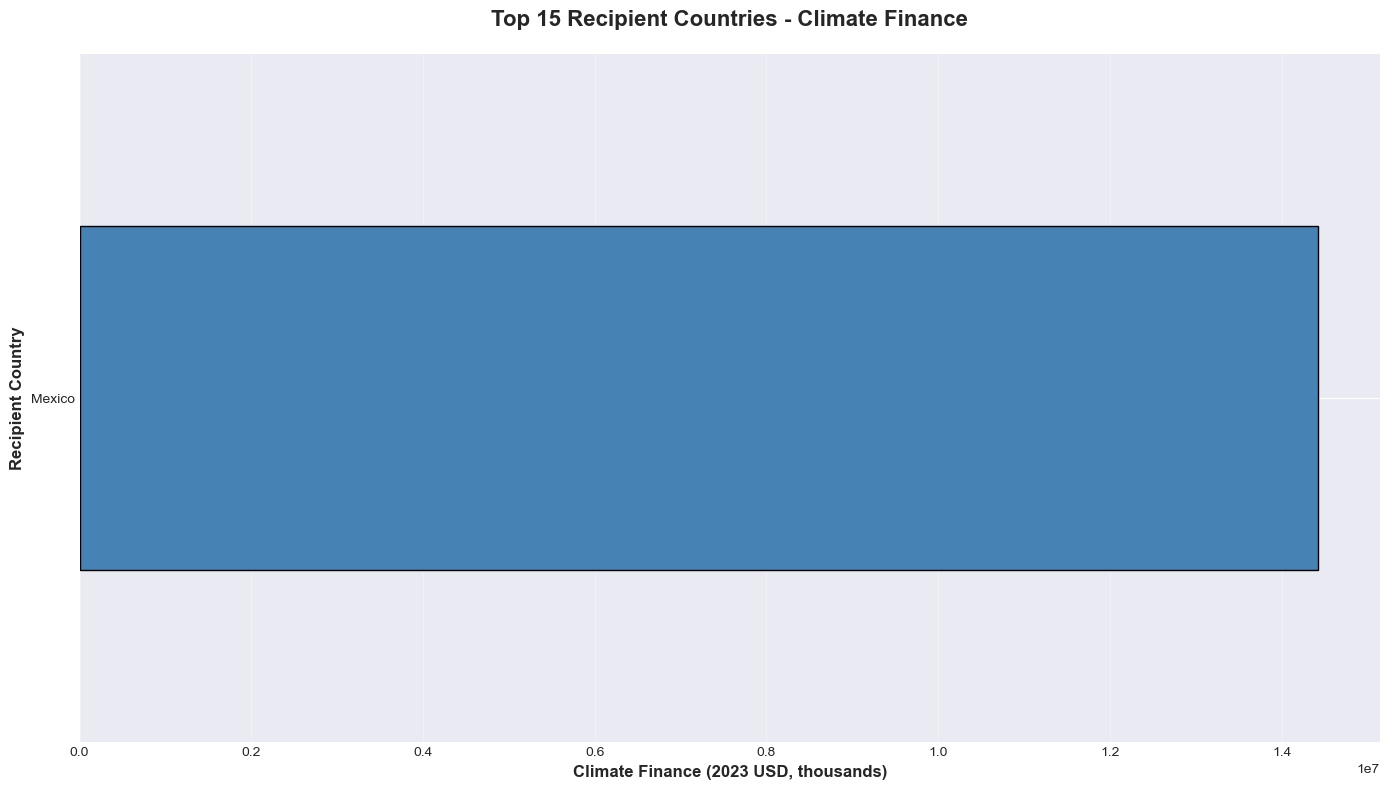


Top 15 Recipient Countries:
Recipient
Mexico    14.42
Name: Climate-related development finance - Commitment - 2023 USD thousand, dtype: float64


In [11]:
# Aggregate by recipient country
if 'Recipient' in df.columns:
    finance_by_recipient = df.groupby('Recipient')[climate_finance_col].sum().sort_values(ascending=False)
    
    # Get top 15 countries
    top_recipients = finance_by_recipient.head(15)
    
    # Create bar chart
    plt.figure(figsize=(14, 8))
    top_recipients.plot(kind='barh', color='steelblue', edgecolor='black')
    plt.title('Top 15 Recipient Countries - Climate Finance', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Climate Finance (2023 USD, thousands)', fontsize=12, fontweight='bold')
    plt.ylabel('Recipient Country', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop 15 Recipient Countries:")
    print((top_recipients / 1e6).round(2))

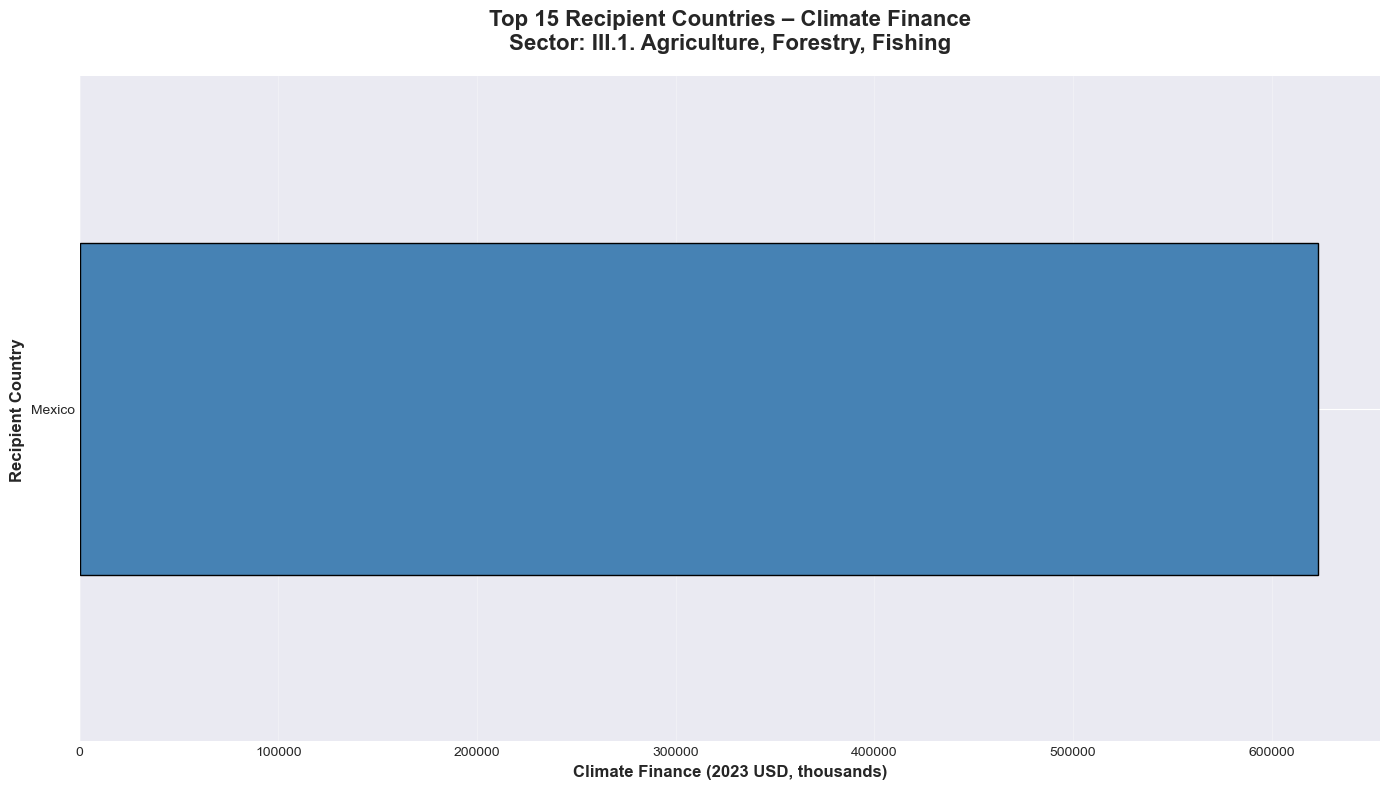


Top 15 Recipient Countries — Sector: III.1. Agriculture, Forestry, Fishing
Recipient
Mexico    0.62
Name: Climate-related development finance - Commitment - 2023 USD thousand, dtype: float64


In [12]:
import matplotlib.pyplot as plt

# --- filter to JUST this sector ---
target_sector = "III.1. Agriculture, Forestry, Fishing"

if 'Sector' not in df.columns:
    print("Column 'Sector' not found in df.")
elif 'Recipient' not in df.columns:
    print("Column 'Recipient' not found in df.")
else:
    # Filter to sector
    df_sector = df[df['Sector'].astype(str).str.strip() == target_sector].copy()

    if df_sector.empty:
        print(f"No rows found for Sector = {target_sector!r}")
    else:
        # Aggregate by recipient country (sector-only)
        finance_by_recipient = (
            df_sector
            .groupby('Recipient')[climate_finance_col]
            .sum()
            .sort_values(ascending=False)
        )

        # Get top 15 countries
        top_recipients = finance_by_recipient.head(15)

        # Create bar chart
        plt.figure(figsize=(14, 8))

        top_recipients.plot(
            kind='barh',
            color='steelblue',
            edgecolor='black'
        )

        plt.title(
            f'Top 15 Recipient Countries – Climate Finance\nSector: {target_sector}',
            fontsize=16,
            fontweight='bold',
            pad=20
        )

        plt.xlabel('Climate Finance (2023 USD, thousands)', fontsize=12, fontweight='bold')
        plt.ylabel('Recipient Country', fontsize=12, fontweight='bold')

        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print values
        print(f"\nTop 15 Recipient Countries — Sector: {target_sector}")
        print((top_recipients / 1e6).round(2))


In [13]:
target_sector = "III.1. Agriculture, Forestry, Fishing"

if 'Sector' not in df.columns:
    print("Column 'Sector' not found in df.")
else:
    sector_count = (
        df['Sector']
        .astype(str)
        .str.strip()
        .eq(target_sector)
        .sum()
    )

    print(f"Number of rows for sector '{target_sector}': {sector_count}")


Number of rows for sector 'III.1. Agriculture, Forestry, Fishing': 217


## 3. Finance by Region (Stacked Bar)

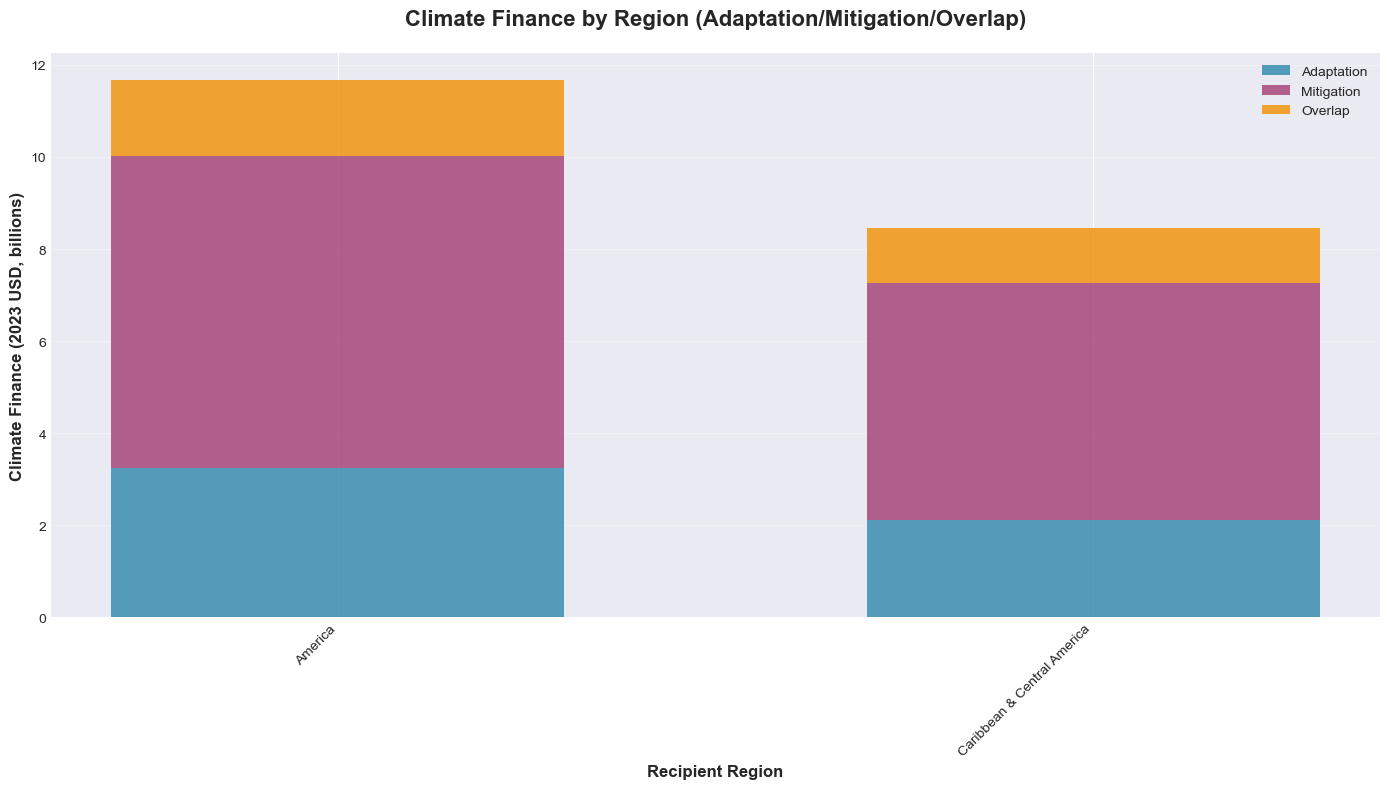


Finance by Region (billions USD):
                             Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Recipient Region                                                                                                          
America                                                                   3.24                                            
Caribbean & Central America                                               2.12                                            

                             Mitigation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Recipient Region                                                                                                          
America                                                                   6.78                                            
Caribbean & Central America                                               5.14                         

In [14]:
# Prepare data for stacked bar chart
adaptation_col = 'Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand'
mitigation_col = 'Mitigation-related development finance (includes overlap) - Commitment - 2023 USD thousand'
overlap_col = 'Overlap - Commitment - 2023 USD thousand'

# Convert to numeric
df[adaptation_col] = pd.to_numeric(df[adaptation_col], errors='coerce')
df[mitigation_col] = pd.to_numeric(df[mitigation_col], errors='coerce')
df[overlap_col] = pd.to_numeric(df[overlap_col], errors='coerce')

if 'Recipient Region' in df.columns:
    # Aggregate by region
    region_finance = df.groupby('Recipient Region').agg({
        adaptation_col: 'sum',
        mitigation_col: 'sum',
        overlap_col: 'sum'
    })
    region_finance['Total'] = region_finance[adaptation_col] + region_finance[mitigation_col] + region_finance[overlap_col]
    region_finance = region_finance.sort_values('Total', ascending=False)
    
    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = range(len(region_finance))
    width = 0.6
    
    # Plot stacked bars
    p1 = ax.bar(x, region_finance[adaptation_col] / 1e6, width, label='Adaptation', color='#2E86AB', alpha=0.8)
    p2 = ax.bar(x, region_finance[mitigation_col] / 1e6, width, 
                bottom=region_finance[adaptation_col] / 1e6, label='Mitigation', color='#A23B72', alpha=0.8)
    p3 = ax.bar(x, region_finance[overlap_col] / 1e6, width,
                bottom=(region_finance[adaptation_col] + region_finance[mitigation_col]) / 1e6, 
                label='Overlap', color='#F18F01', alpha=0.8)
    
    ax.set_xlabel('Recipient Region', fontsize=12, fontweight='bold')
    ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    ax.set_title('Climate Finance by Region (Adaptation/Mitigation/Overlap)', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(region_finance.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nFinance by Region (billions USD):")
    print((region_finance[[adaptation_col, mitigation_col, overlap_col]] / 1e6).round(2))

## 4. Adaptation vs Mitigation Balance

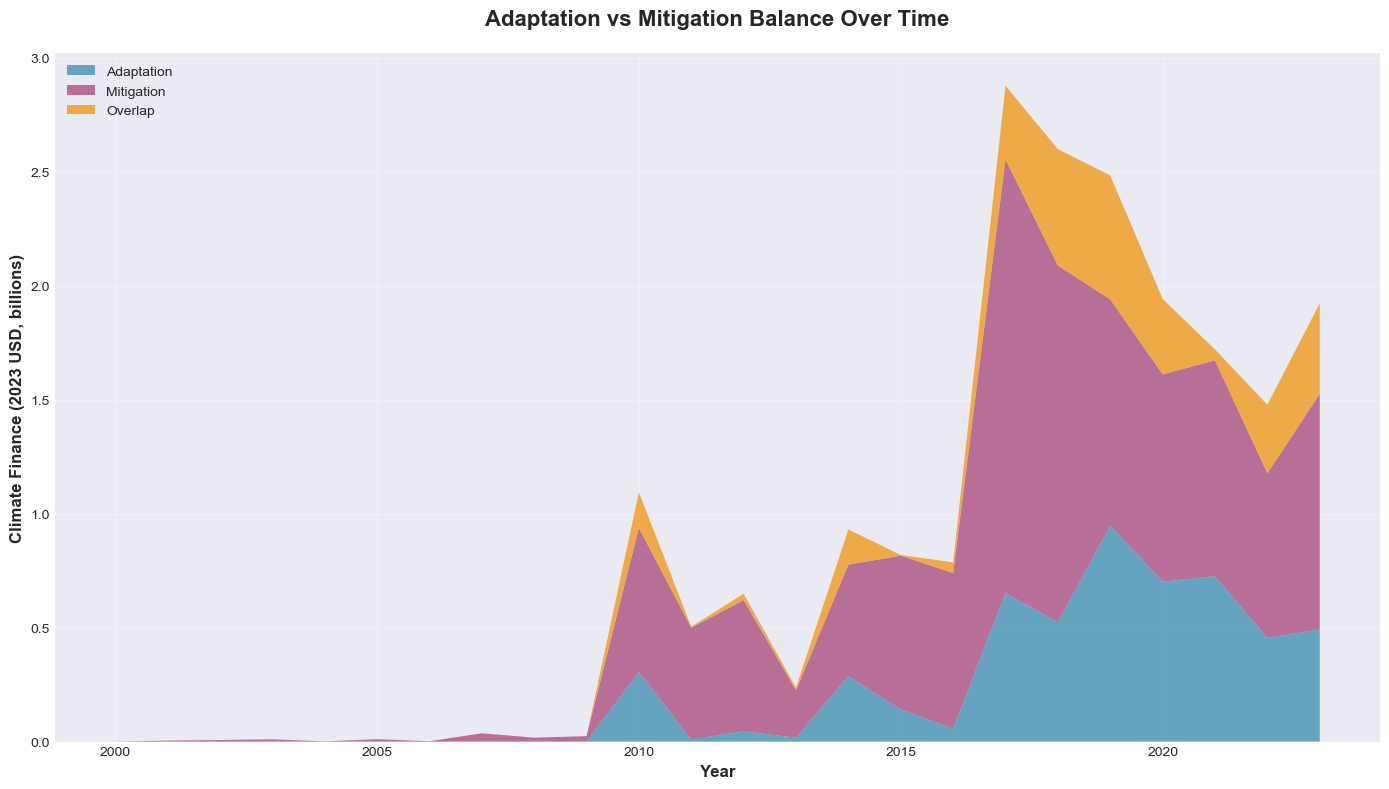

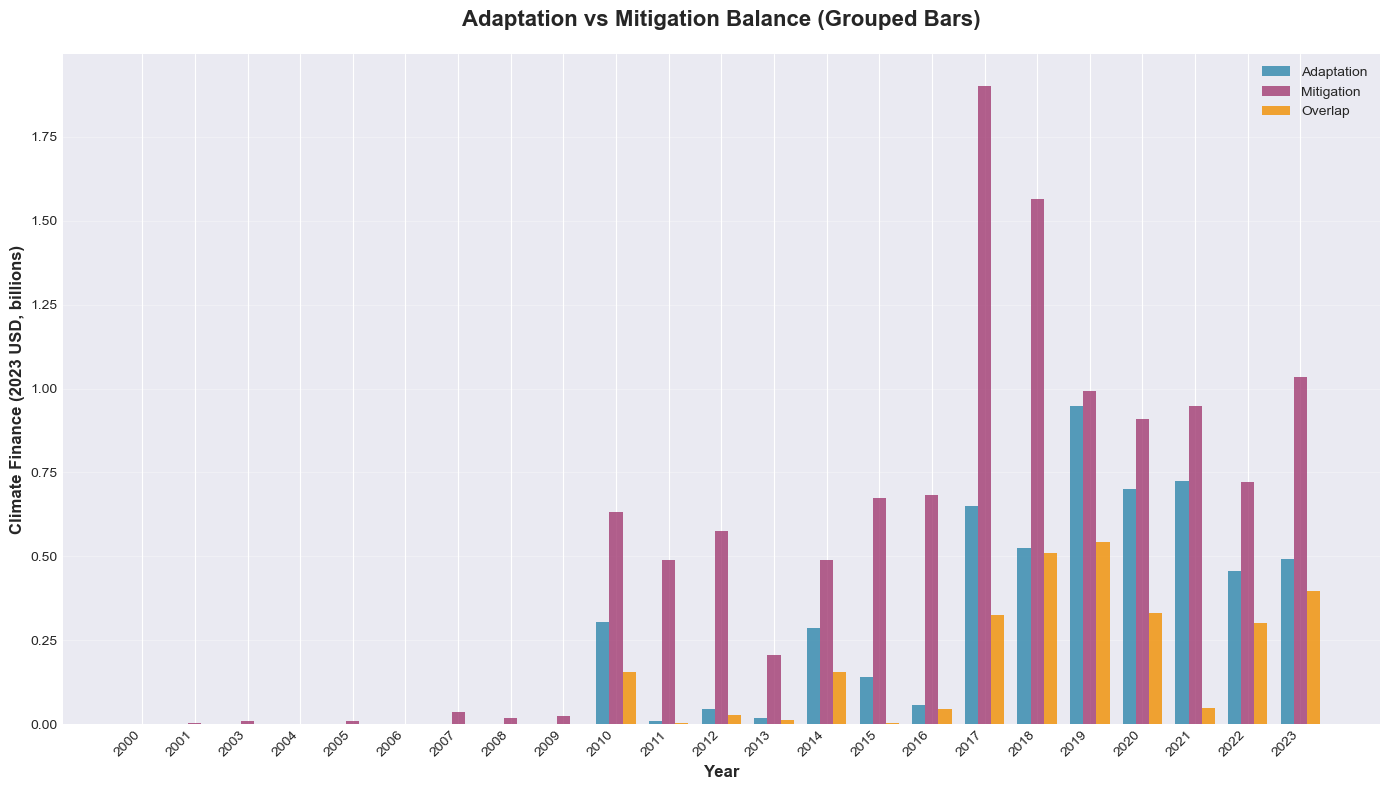

In [15]:
# Aggregate by year
yearly_balance = df.groupby('Year').agg({
    adaptation_col: 'sum',
    mitigation_col: 'sum',
    overlap_col: 'sum'
}).sort_index()

# Create stacked area chart
plt.figure(figsize=(14, 8))
plt.stackplot(yearly_balance.index, 
              yearly_balance[adaptation_col] / 1e6,
              yearly_balance[mitigation_col] / 1e6,
              yearly_balance[overlap_col] / 1e6,
              labels=['Adaptation', 'Mitigation', 'Overlap'],
              colors=['#2E86AB', '#A23B72', '#F18F01'],
              alpha=0.7)

plt.title('Adaptation vs Mitigation Balance Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Also create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(yearly_balance))
width = 0.25

ax.bar(x - width, yearly_balance[adaptation_col] / 1e6, width, label='Adaptation', color='#2E86AB', alpha=0.8)
ax.bar(x, yearly_balance[mitigation_col] / 1e6, width, label='Mitigation', color='#A23B72', alpha=0.8)
ax.bar(x + width, yearly_balance[overlap_col] / 1e6, width, label='Overlap', color='#F18F01', alpha=0.8)

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
ax.set_title('Adaptation vs Mitigation Balance (Grouped Bars)', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(yearly_balance.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

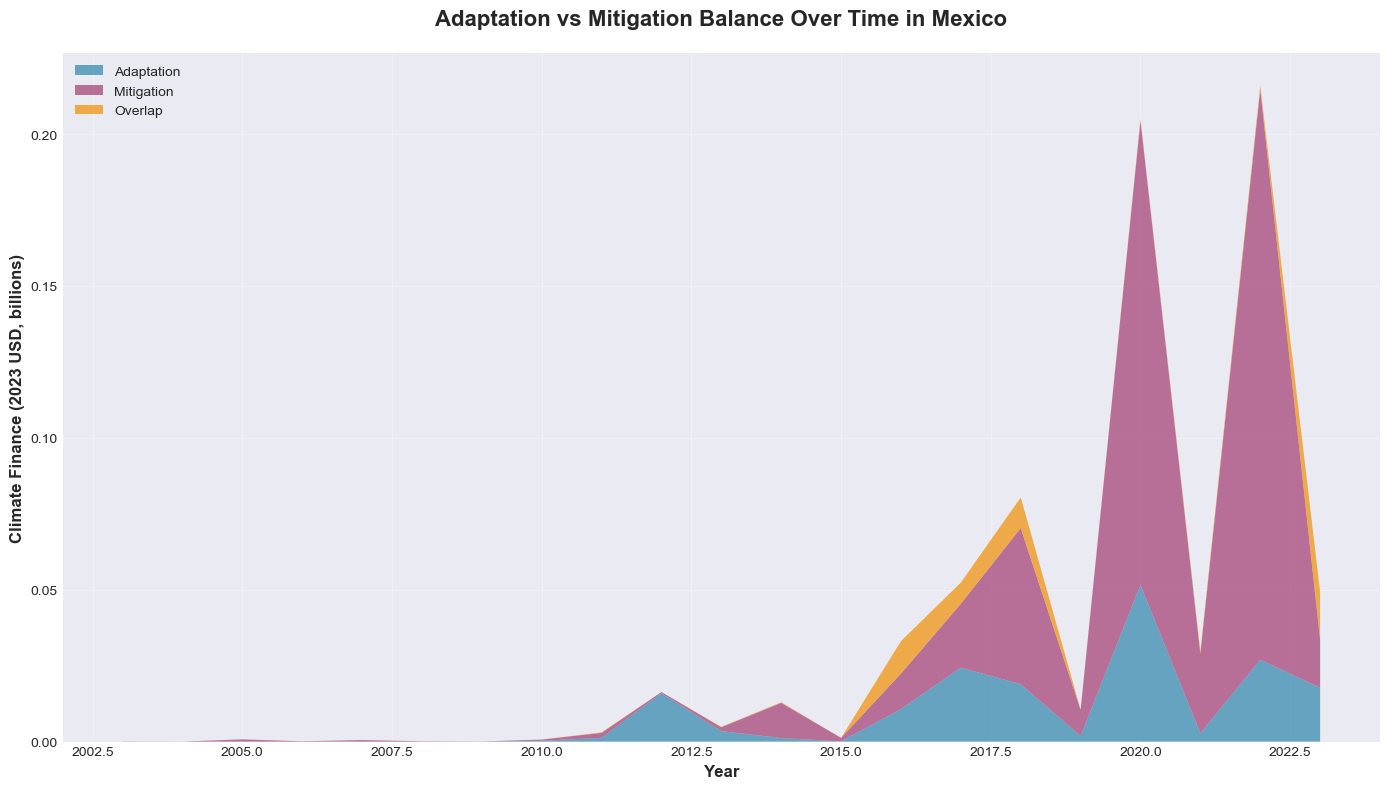

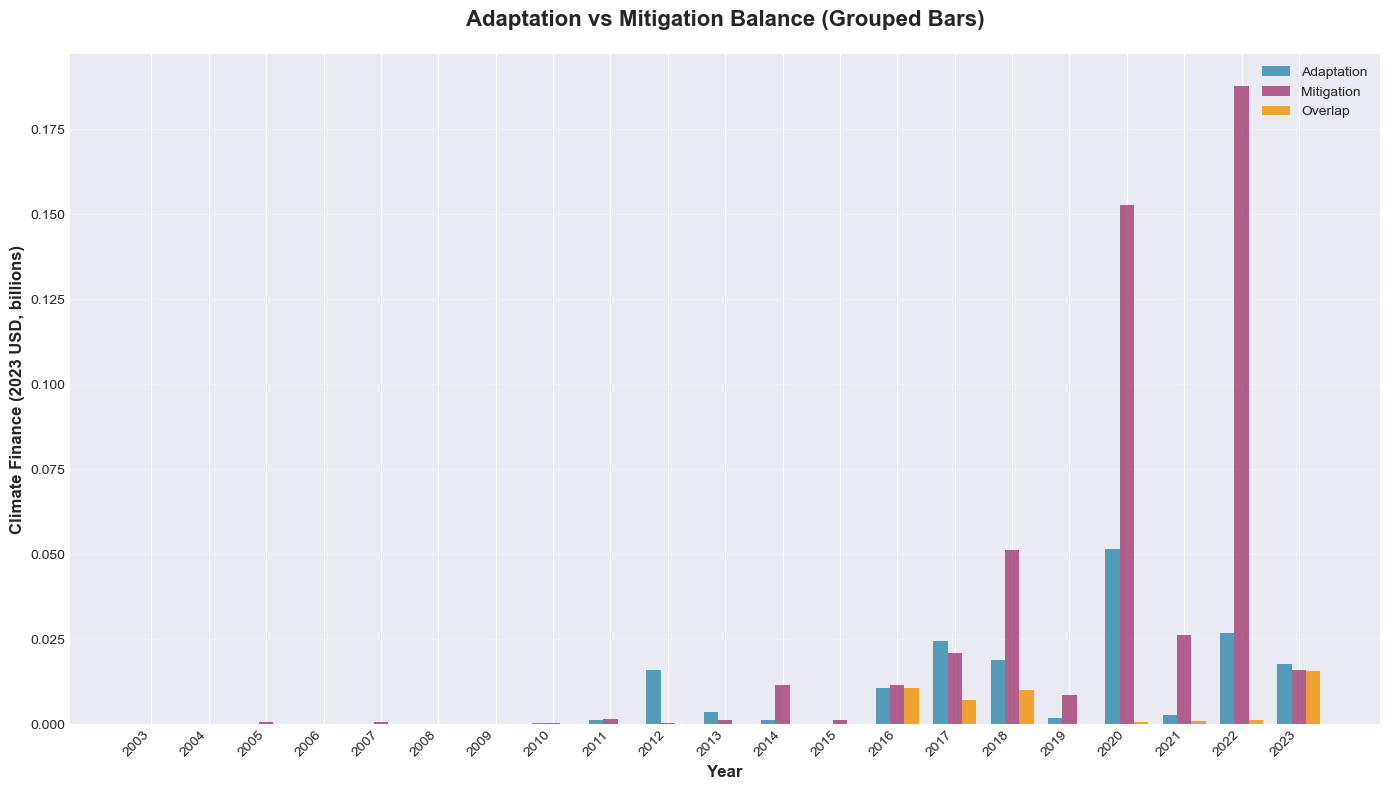

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# --- filter to JUST this sector ---
target_sector = "III.1. Agriculture, Forestry, Fishing"

if 'Sector' not in df.columns:
    print("Column 'Sector' not found in df.")
elif 'Year' not in df.columns:
    print("Column 'Year' not found in df.")
else:
    df_sector = df[df['Sector'].astype(str).str.strip() == target_sector].copy()
    len(df_sector)

    if df_sector.empty:
        print(f"No rows found for Sector = {target_sector!r}")
    else:
        # Aggregate by year (sector-only)
        yearly_balance = (
            df_sector.groupby('Year')
            .agg({
                adaptation_col: 'sum',
                mitigation_col: 'sum',
                overlap_col: 'sum'
            })
            .sort_index()
        )

        # Create stacked area chart
        plt.figure(figsize=(14, 8))
        plt.stackplot(
            yearly_balance.index,
            yearly_balance[adaptation_col] / 1e6,
            yearly_balance[mitigation_col] / 1e6,
            yearly_balance[overlap_col] / 1e6,
            labels=['Adaptation', 'Mitigation', 'Overlap'],
            colors=['#2E86AB', '#A23B72', '#F18F01'],
            alpha=0.7
        )

        plt.title(
            f'Adaptation vs Mitigation Balance Over Time in Mexico',
            fontsize=16,
            fontweight='bold',
            pad=20
        )
        plt.xlabel('Year', fontsize=12, fontweight='bold')
        plt.ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Grouped bar chart
        fig, ax = plt.subplots(figsize=(14, 8))
        x = np.arange(len(yearly_balance))
        width = 0.25

        ax.bar(
            x - width,
            yearly_balance[adaptation_col] / 1e6,
            width,
            label='Adaptation',
            color='#2E86AB',
            alpha=0.8
        )
        ax.bar(
            x,
            yearly_balance[mitigation_col] / 1e6,
            width,
            label='Mitigation',
            color='#A23B72',
            alpha=0.8
        )
        ax.bar(
            x + width,
            yearly_balance[overlap_col] / 1e6,
            width,
            label='Overlap',
            color='#F18F01',
            alpha=0.8
        )

        ax.set_xlabel('Year', fontsize=12, fontweight='bold')
        ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
        ax.set_title(
            f'Adaptation vs Mitigation Balance (Grouped Bars)',
            fontsize=16,
            fontweight='bold',
            pad=20
        )
        ax.set_xticks(x)
        ax.set_xticklabels(yearly_balance.index, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()


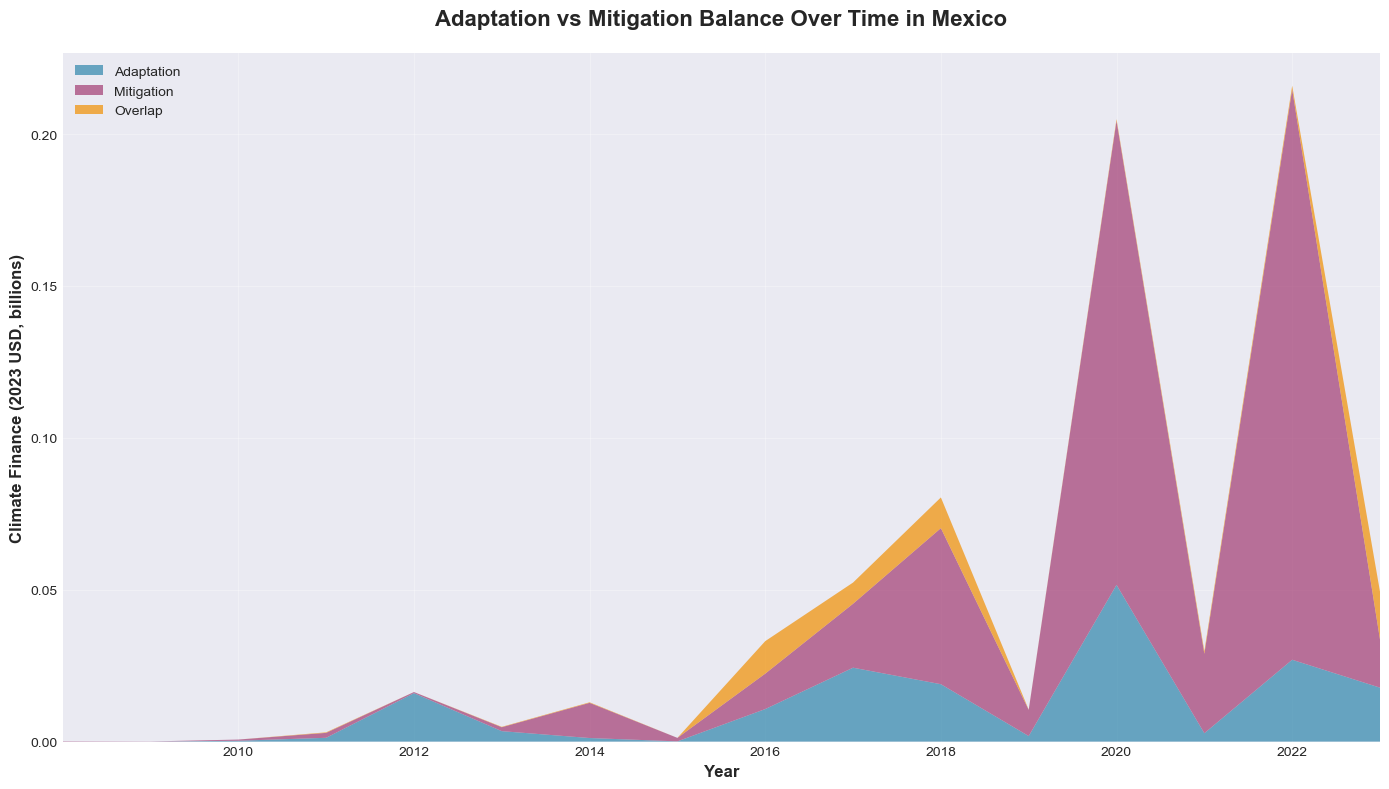

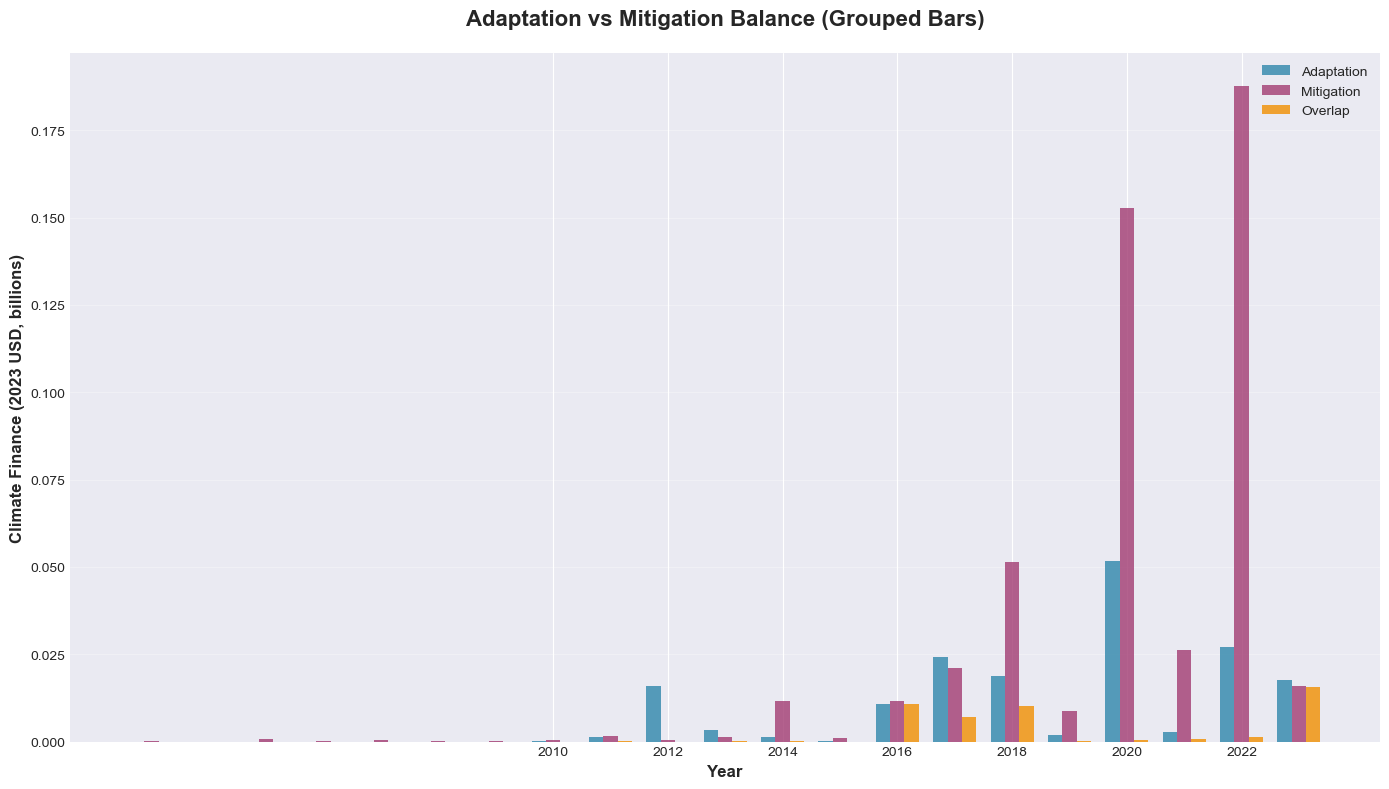

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# --- filter to JUST this sector ---
target_sector = "III.1. Agriculture, Forestry, Fishing"

if 'Sector' not in df.columns:
    print("Column 'Sector' not found in df.")
elif 'Year' not in df.columns:
    print("Column 'Year' not found in df.")
else:
    df_sector = df[df['Sector'].astype(str).str.strip() == target_sector].copy()

    if df_sector.empty:
        print(f"No rows found for Sector = {target_sector!r}")
    else:
        # Aggregate by year (sector-only)
        yearly_balance = (
            df_sector.groupby('Year')
            .agg({
                adaptation_col: 'sum',
                mitigation_col: 'sum',
                overlap_col: 'sum'
            })
            .sort_index()
        )

        # Make sure Year is numeric + sorted
        yearly_balance.index = yearly_balance.index.astype(int)
        yearly_balance = yearly_balance.sort_index()

        years = yearly_balance.index.to_numpy()
        max_year = int(years.max())

        # ticks: start at 2010, increment by 5, stop at max year
        tick_years = np.arange(2010, max_year + 1, 2)

        # -----------------------------
        # Stacked area chart
        # -----------------------------
        plt.figure(figsize=(14, 8))
        plt.stackplot(
            years,
            yearly_balance[adaptation_col] / 1e6,
            yearly_balance[mitigation_col] / 1e6,
            yearly_balance[overlap_col] / 1e6,
            labels=['Adaptation', 'Mitigation', 'Overlap'],
            colors=['#2E86AB', '#A23B72', '#F18F01'],
            alpha=0.7
        )

        plt.title('Adaptation vs Mitigation Balance Over Time in Mexico', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Year', fontsize=12, fontweight='bold')
        plt.ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)

        # Force x-axis to start at 2010 and show 5-year ticks
        plt.xlim(2008, max_year)
        plt.xticks(tick_years)

        plt.tight_layout()
        plt.show()

        # -----------------------------
        # Grouped bar chart
        # -----------------------------
        fig, ax = plt.subplots(figsize=(14, 8))

        x = np.arange(len(yearly_balance))
        width = 0.25

        ax.bar(x - width, yearly_balance[adaptation_col] / 1e6, width, label='Adaptation',
               color='#2E86AB', alpha=0.8)
        ax.bar(x, yearly_balance[mitigation_col] / 1e6, width, label='Mitigation',
               color='#A23B72', alpha=0.8)
        ax.bar(x + width, yearly_balance[overlap_col] / 1e6, width, label='Overlap',
               color='#F18F01', alpha=0.8)

        ax.set_xlabel('Year', fontsize=12, fontweight='bold')
        ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
        ax.set_title('Adaptation vs Mitigation Balance (Grouped Bars)', fontsize=16, fontweight='bold', pad=20)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        # Only label ticks at 2010, 2015, 2020, ...
        year_to_pos = {year: i for i, year in enumerate(years)}
        tick_positions = [year_to_pos[y] for y in tick_years if y in year_to_pos]

        ax.set_xticks(tick_positions)
        ax.set_xticklabels([y for y in tick_years if y in year_to_pos], rotation=0)

        plt.tight_layout()
        plt.show()


In [27]:
df_sector = df[df['Sector'].astype(str).str.strip() == target_sector].copy()
len(df_sector)

217

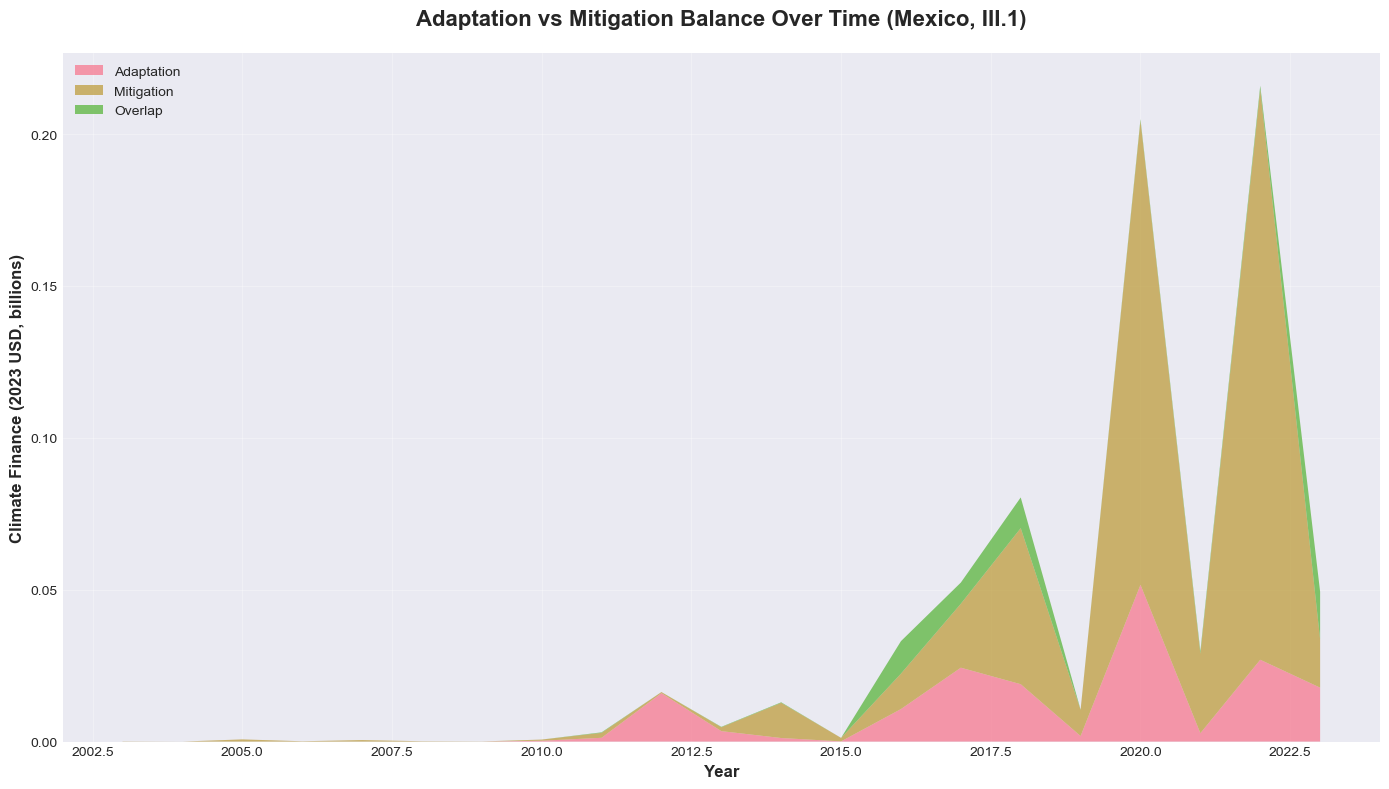

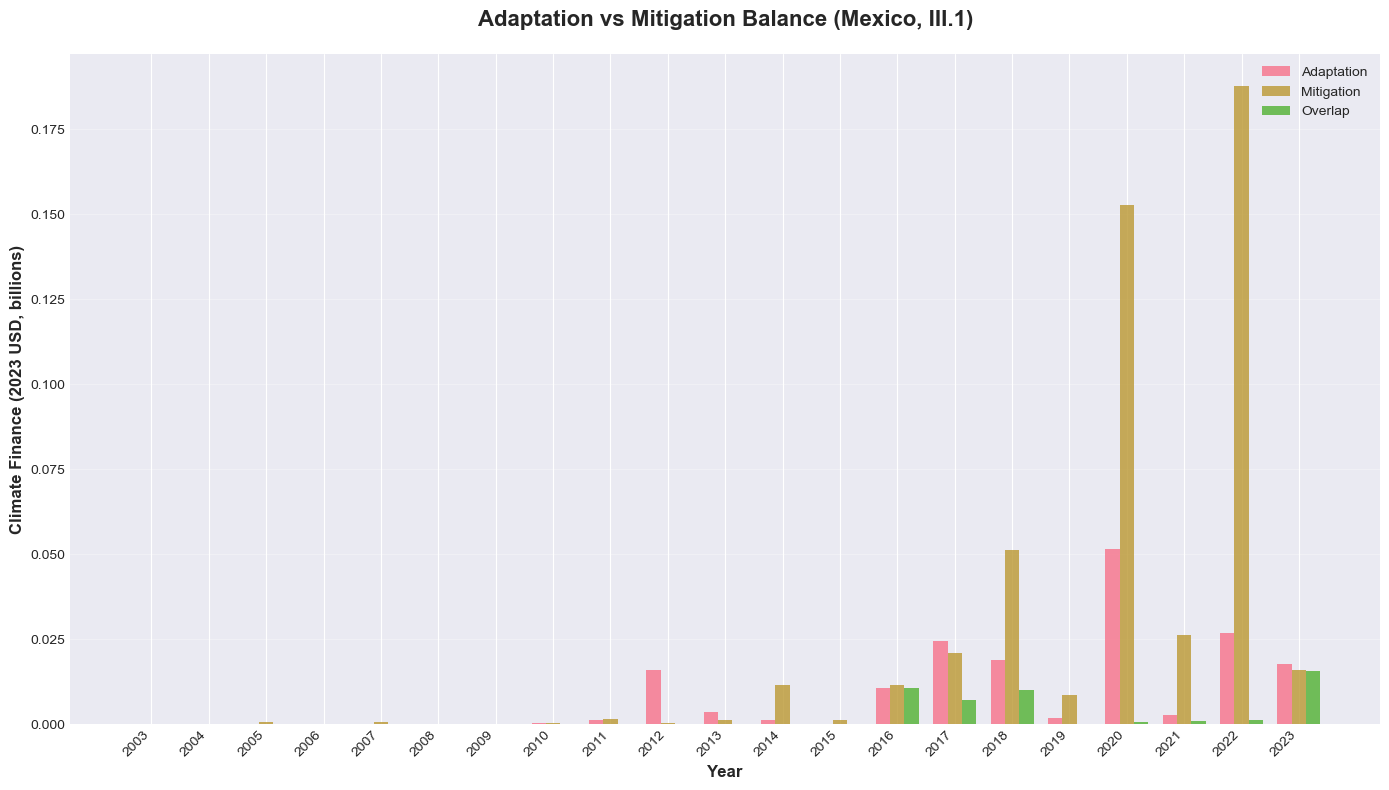

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# --- filters ---
target_sector = "III.1. Agriculture, Forestry, Fishing"
target_country = "Mexico"

# Check required columns
required_cols = ["Sector", "Year", "Recipient"]
missing = [col for col in required_cols if col not in df.columns]

if missing:
    print(f"Missing columns: {missing}")

else:
    # Filter by Sector + Recipient
    df_sector = df[
        (df["Sector"].astype(str).str.strip() == target_sector) &
        (df["Recipient"].astype(str).str.strip() == target_country)
    ].copy()

    if df_sector.empty:
        print(
            f"No rows found for Sector = {target_sector!r} "
            f"and Recipient = {target_country}"
        )

    else:
        # Aggregate by year
        yearly_balance = (
            df_sector.groupby("Year")
            .agg({
                adaptation_col: "sum",
                mitigation_col: "sum",
                overlap_col: "sum"
            })
            .sort_index()
        )

        # -------- Stacked Area Chart --------
        plt.figure(figsize=(14, 8))

        plt.stackplot(
            yearly_balance.index,
            yearly_balance[adaptation_col] / 1e6,
            yearly_balance[mitigation_col] / 1e6,
            yearly_balance[overlap_col] / 1e6,
            labels=["Adaptation", "Mitigation", "Overlap"],
            alpha=0.7
        )

        plt.title(
            "Adaptation vs Mitigation Balance Over Time (Mexico, III.1)",
            fontsize=16,
            fontweight="bold",
            pad=20
        )
        plt.xlabel("Year", fontsize=12, fontweight="bold")
        plt.ylabel("Climate Finance (2023 USD, billions)", fontsize=12, fontweight="bold")
        plt.legend(loc="upper left")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


        # -------- Grouped Bar Chart --------
        fig, ax = plt.subplots(figsize=(14, 8))

        x = np.arange(len(yearly_balance))
        width = 0.25

        ax.bar(
            x - width,
            yearly_balance[adaptation_col] / 1e6,
            width,
            label="Adaptation",
            alpha=0.8
        )
        ax.bar(
            x,
            yearly_balance[mitigation_col] / 1e6,
            width,
            label="Mitigation",
            alpha=0.8
        )
        ax.bar(
            x + width,
            yearly_balance[overlap_col] / 1e6,
            width,
            label="Overlap",
            alpha=0.8
        )

        ax.set_xlabel("Year", fontsize=12, fontweight="bold")
        ax.set_ylabel("Climate Finance (2023 USD, billions)", fontsize=12, fontweight="bold")
        ax.set_title(
            "Adaptation vs Mitigation Balance (Mexico, III.1)",
            fontsize=16,
            fontweight="bold",
            pad=20
        )

        ax.set_xticks(x)
        ax.set_xticklabels(yearly_balance.index, rotation=45, ha="right")

        ax.legend()
        ax.grid(axis="y", alpha=0.3)
        plt.tight_layout()
        plt.show()


## 5. Distribution by Income Group (Equity)

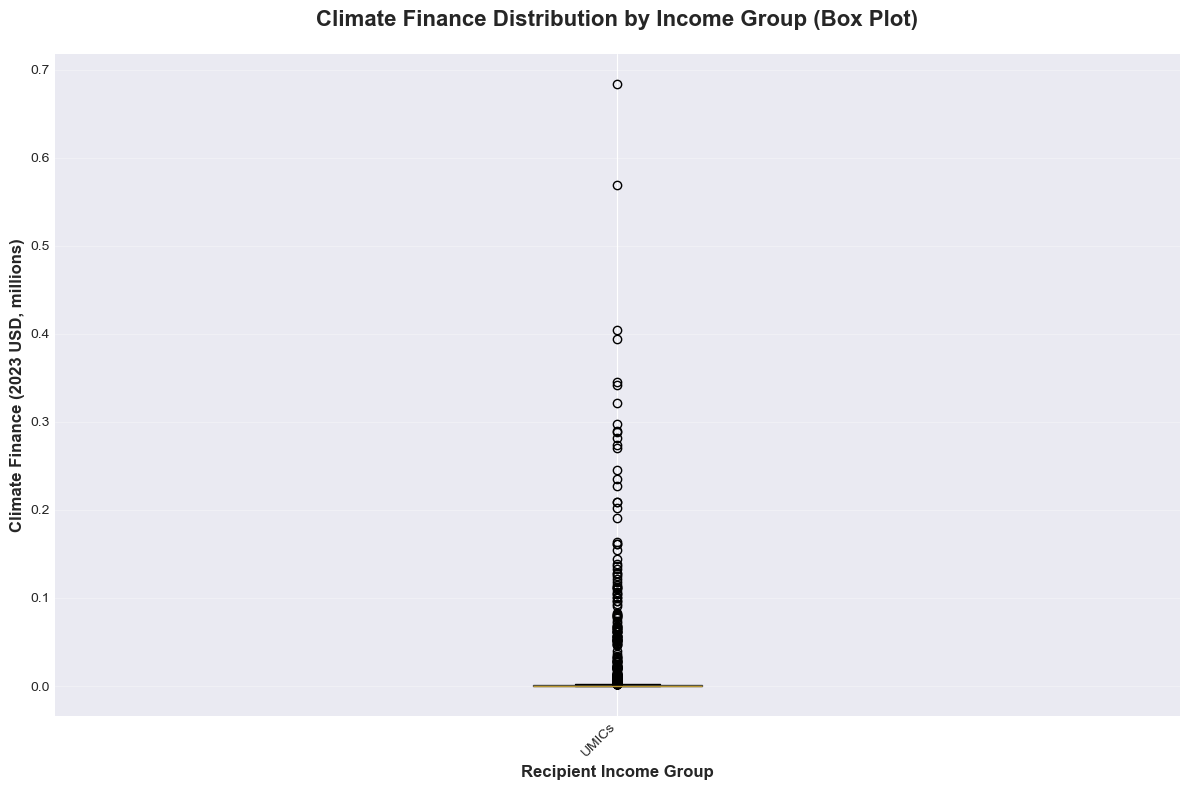

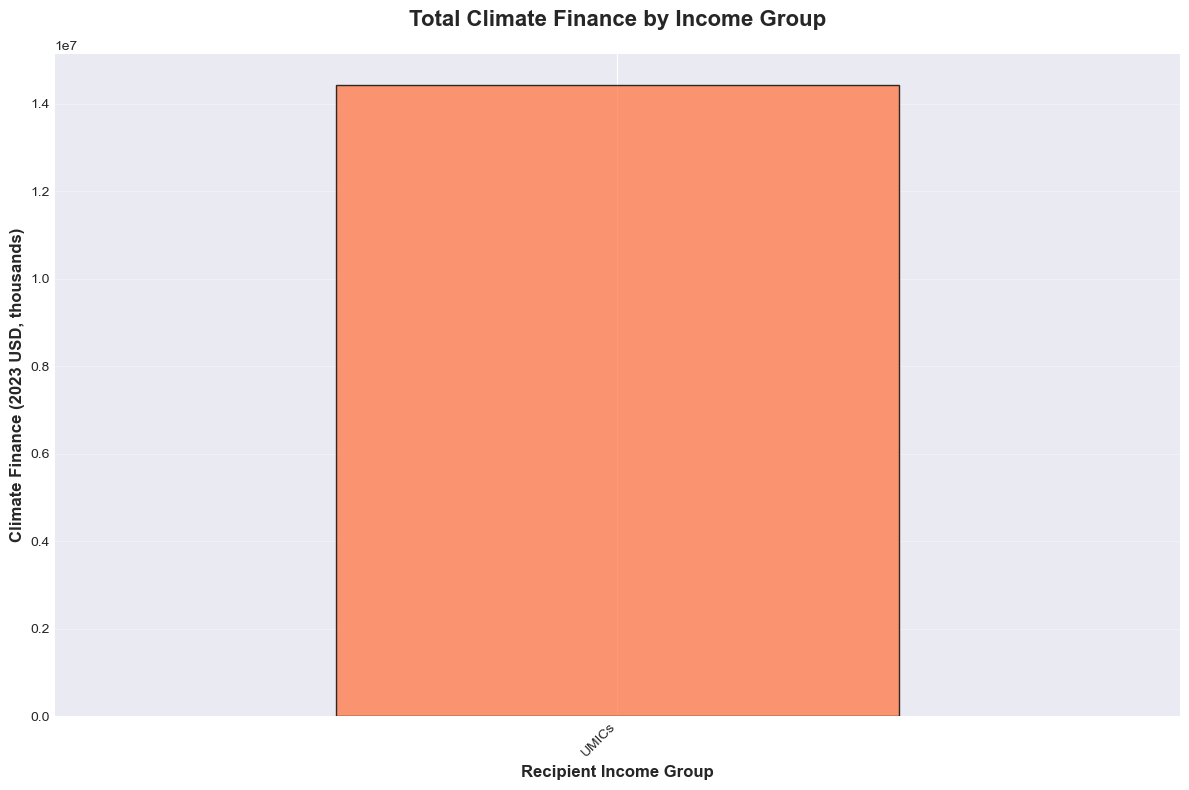


Total Finance by Income Group:
Recipient Income Group (OECD Classification)
UMICs    14.42
Name: Climate-related development finance - Commitment - 2023 USD thousand, dtype: float64


In [19]:
if 'Recipient Income Group (OECD Classification)' in df.columns:
    # Box plot
    income_data = df[df[climate_finance_col].notna() & df['Recipient Income Group (OECD Classification)'].notna()]
    
    plt.figure(figsize=(12, 8))
    income_groups = income_data['Recipient Income Group (OECD Classification)'].unique()
    data_to_plot = [income_data[income_data['Recipient Income Group (OECD Classification)'] == group][climate_finance_col].dropna() / 1e6 
                    for group in income_groups]
    
    bp = plt.boxplot(data_to_plot, labels=income_groups, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    plt.title('Climate Finance Distribution by Income Group (Box Plot)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Recipient Income Group', fontsize=12, fontweight='bold')
    plt.ylabel('Climate Finance (2023 USD, millions)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Bar chart (aggregated totals)
    income_totals = df.groupby('Recipient Income Group (OECD Classification)')[climate_finance_col].sum().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 8))
    income_totals.plot(kind='bar', color='coral', edgecolor='black', alpha=0.8)
    plt.title('Total Climate Finance by Income Group', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Recipient Income Group', fontsize=12, fontweight='bold')
    plt.ylabel('Climate Finance (2023 USD, thousands)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nTotal Finance by Income Group:")
    print((income_totals / 1e6).round(2))

## 6. Sector Allocation of Climate Finance

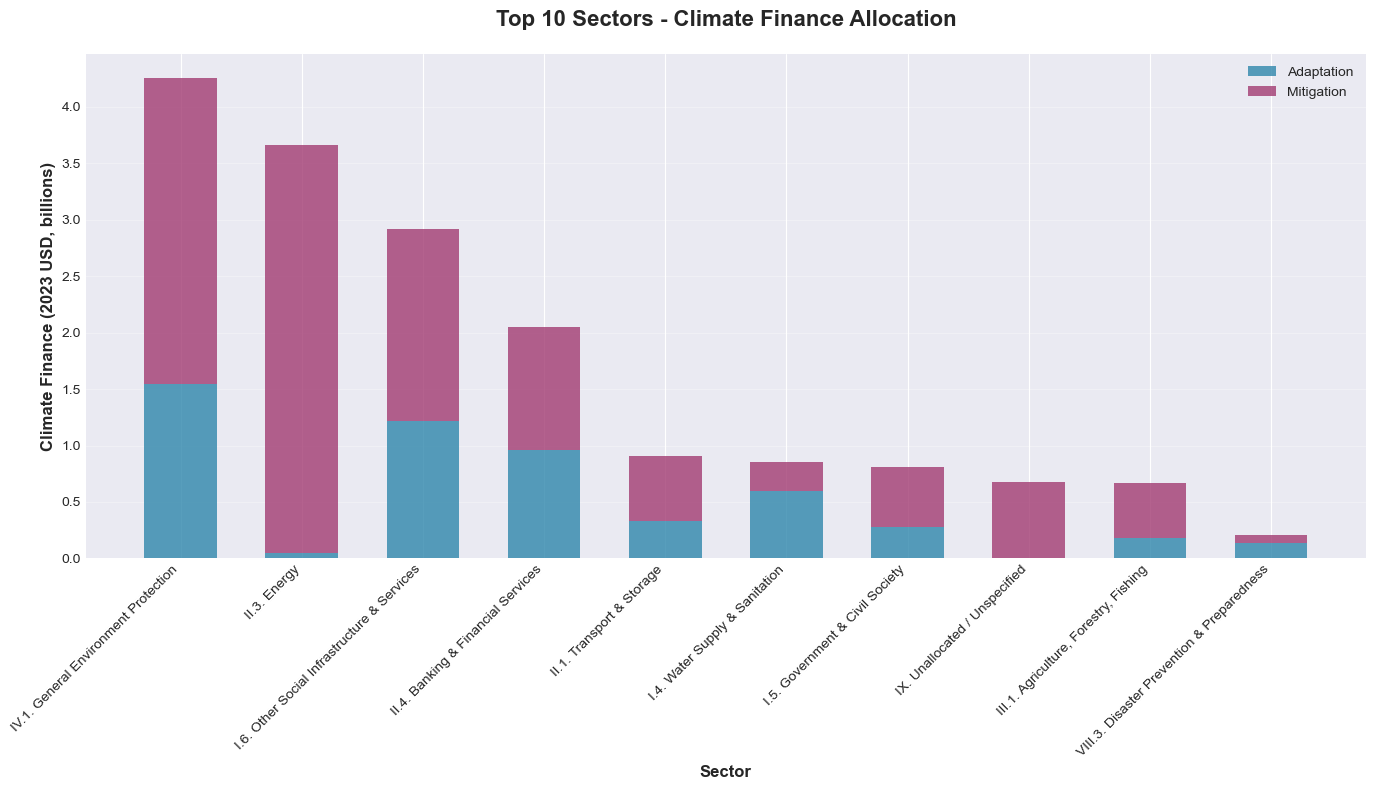


Top 10 Sectors (billions USD):
                                             Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Sector                                                                                                                                    
IV.1. General Environment Protection                                                      1.55                                            
II.3. Energy                                                                              0.05                                            
I.6. Other Social Infrastructure & Services                                               1.22                                            
II.4. Banking & Financial Services                                                        0.96                                            
II.1. Transport & Storage                                                                 0.33                                        

In [20]:
if 'Sector' in df.columns:
    # Aggregate by sector
    sector_finance = df.groupby('Sector').agg({
        adaptation_col: 'sum',
        mitigation_col: 'sum'
    })
    sector_finance['Total'] = sector_finance[adaptation_col] + sector_finance[mitigation_col]
    sector_finance = sector_finance.sort_values('Total', ascending=False).head(10)
    
    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = range(len(sector_finance))
    width = 0.6
    
    p1 = ax.bar(x, sector_finance[adaptation_col] / 1e6, width, label='Adaptation', color='#2E86AB', alpha=0.8)
    p2 = ax.bar(x, sector_finance[mitigation_col] / 1e6, width, 
                bottom=sector_finance[adaptation_col] / 1e6, label='Mitigation', color='#A23B72', alpha=0.8)
    
    ax.set_xlabel('Sector', fontsize=12, fontweight='bold')
    ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    ax.set_title('Top 10 Sectors - Climate Finance Allocation', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(sector_finance.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Sectors (billions USD):")
    print((sector_finance[[adaptation_col, mitigation_col]] / 1e6).round(2))

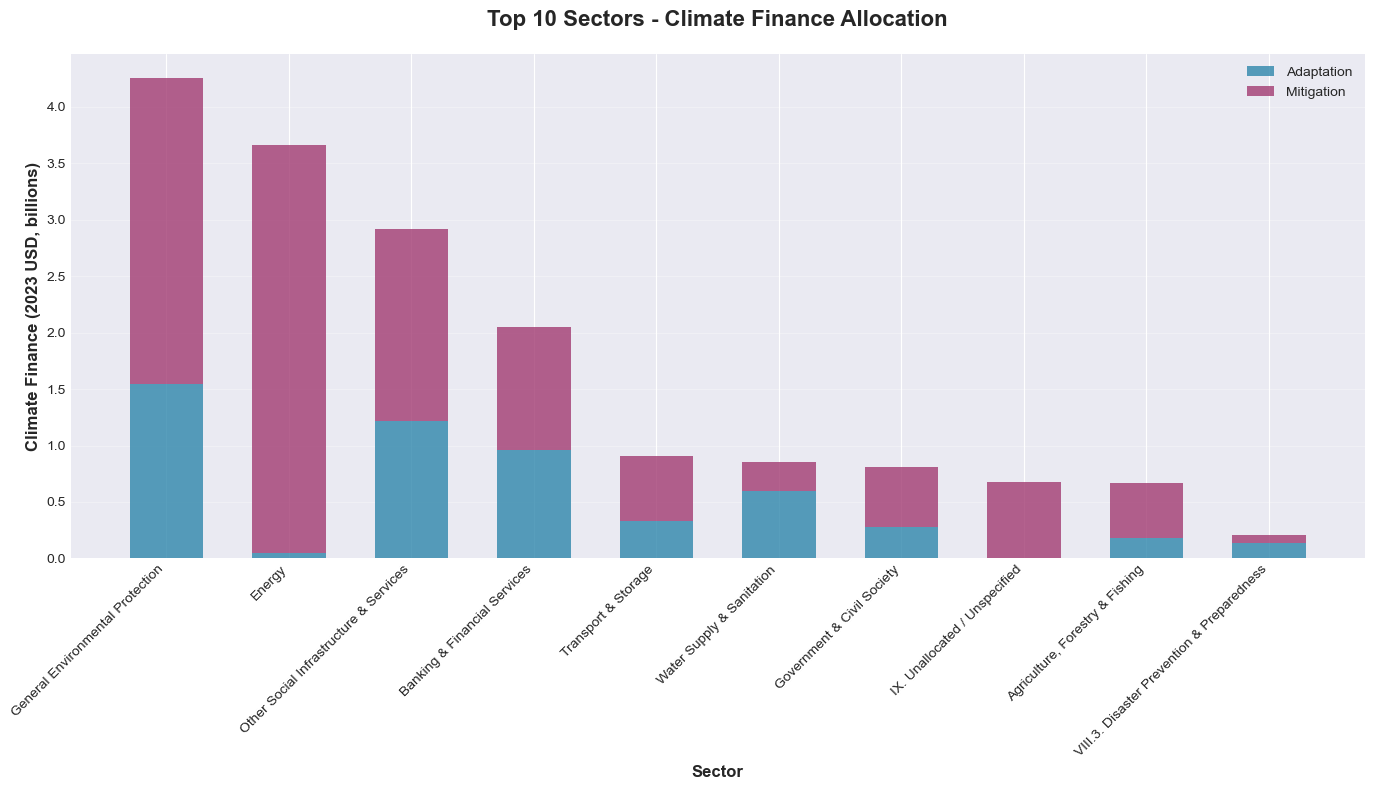


Top 10 Sectors (billions USD):
                                            Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Sector                                                                                                                                   
General Environmental Protection                                                         1.55                                            
Energy                                                                                   0.05                                            
Other Social Infrastructure & Services                                                   1.22                                            
Banking & Financial Services                                                             0.96                                            
Transport & Storage                                                                      0.33                                            
Wa

In [21]:
import matplotlib.pyplot as plt

if 'Sector' in df.columns:

    # Rename map for cleaner labels
    sector_rename_map = {
        "II.3. Energy": "Energy",
        "II.1. Transport & Storage": "Transport & Storage",
        "III.1. Agriculture, Forestry, Fishing": "Agriculture, Forestry & Fishing",
        "IV.1. General Environment Protection": "General Environmental Protection",
        "I.4. Water Supply & Sanitation": "Water Supply & Sanitation",
        "IV.2. Other Multisector": "Other Multisector",
        "II.4. Banking & Financial Services": "Banking & Financial Services",
        "I.5. Government & Civil Society": "Government & Civil Society",
        "I.6. Other Social Infrastructure & Services": "Other Social Infrastructure & Services",
        "I.2. Health": "Health"
    }

    # Aggregate by sector
    sector_finance = df.groupby('Sector').agg({
        adaptation_col: 'sum',
        mitigation_col: 'sum'
    })

    # Rename sector labels
    sector_finance = sector_finance.rename(index=sector_rename_map)

    # Compute total
    sector_finance['Total'] = (
        sector_finance[adaptation_col] + sector_finance[mitigation_col]
    )

    # Top 10 by total
    sector_finance = sector_finance.sort_values('Total', ascending=False).head(10)

    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 8))

    x = range(len(sector_finance))
    width = 0.6

    # Same colors as before
    p1 = ax.bar(
        x,
        sector_finance[adaptation_col] / 1e6,
        width,
        label='Adaptation',
        color='#2E86AB',   # Blue
        alpha=0.8
    )

    p2 = ax.bar(
        x,
        sector_finance[mitigation_col] / 1e6,
        width,
        bottom=sector_finance[adaptation_col] / 1e6,
        label='Mitigation',
        color='#A23B72',   # Pink
        alpha=0.8
    )

    ax.set_xlabel('Sector', fontsize=12, fontweight='bold')
    ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    ax.set_title(
        'Top 10 Sectors - Climate Finance Allocation',
        fontsize=16,
        fontweight='bold',
        pad=20
    )

    ax.set_xticks(list(x))
    ax.set_xticklabels(sector_finance.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nTop 10 Sectors (billions USD):")
    print((sector_finance[[adaptation_col, mitigation_col]] / 1e6).round(2))

else:
    print("Column 'Sector' not found in df.")



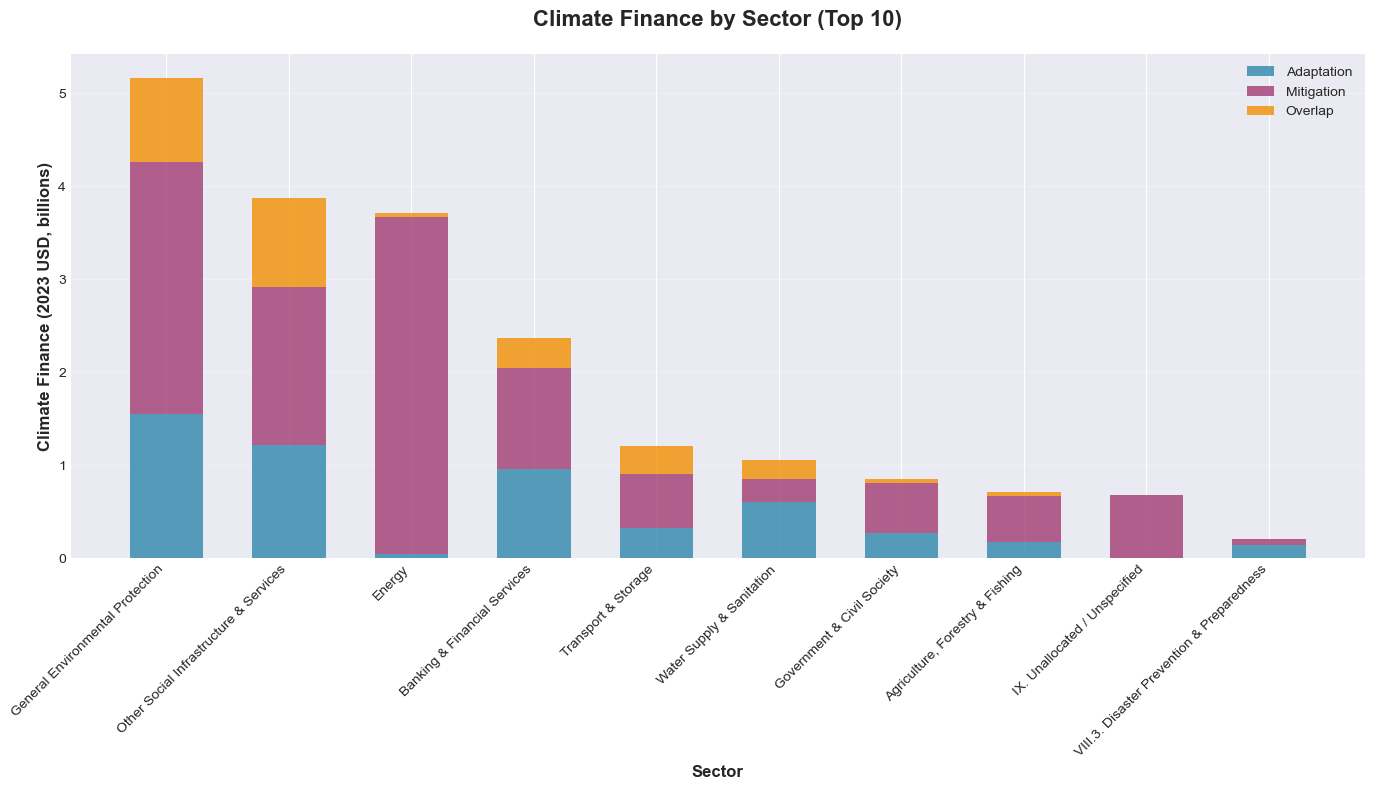


Top 10 Sectors (billions USD):
                                            Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Sector                                                                                                                                   
General Environmental Protection                                                         1.55                                            
Other Social Infrastructure & Services                                                   1.22                                            
Energy                                                                                   0.05                                            
Banking & Financial Services                                                             0.96                                            
Transport & Storage                                                                      0.33                                            
Wa

In [22]:
import matplotlib.pyplot as plt

if 'Sector' in df.columns:

    # Rename map for cleaner labels
    sector_rename_map = {
        "II.3. Energy": "Energy",
        "II.1. Transport & Storage": "Transport & Storage",
        "III.1. Agriculture, Forestry, Fishing": "Agriculture, Forestry & Fishing",
        "IV.1. General Environment Protection": "General Environmental Protection",
        "I.4. Water Supply & Sanitation": "Water Supply & Sanitation",
        "IV.2. Other Multisector": "Other Multisector",
        "II.4. Banking & Financial Services": "Banking & Financial Services",
        "I.5. Government & Civil Society": "Government & Civil Society",
        "I.6. Other Social Infrastructure & Services": "Other Social Infrastructure & Services",
        "I.2. Health": "Health"
    }

    # Aggregate by sector (ADD overlap)
    sector_finance = df.groupby('Sector').agg({
        adaptation_col: 'sum',
        mitigation_col: 'sum',
        overlap_col: 'sum'
    })

    # Rename sector labels
    sector_finance = sector_finance.rename(index=sector_rename_map)

    # Compute total (INCLUDE overlap)
    sector_finance['Total'] = (
        sector_finance[adaptation_col]
        + sector_finance[mitigation_col]
        + sector_finance[overlap_col]
    )

    # Top 10 by total
    sector_finance = sector_finance.sort_values('Total', ascending=False).head(10)

    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 8))

    x = range(len(sector_finance))
    width = 0.6

    # Adaptation
    ax.bar(
        x,
        sector_finance[adaptation_col] / 1e6,
        width,
        label='Adaptation',
        color='#2E86AB',   # Blue
        alpha=0.8
    )

    # Mitigation
    ax.bar(
        x,
        sector_finance[mitigation_col] / 1e6,
        width,
        bottom=sector_finance[adaptation_col] / 1e6,
        label='Mitigation',
        color='#A23B72',   # Pink
        alpha=0.8
    )

    # Overlap (NEW)
    ax.bar(
        x,
        sector_finance[overlap_col] / 1e6,
        width,
        bottom=(
            sector_finance[adaptation_col]
            + sector_finance[mitigation_col]
        ) / 1e6,
        label='Overlap',
        color='#F18F01',   # Orange
        alpha=0.8
    )

    ax.set_xlabel('Sector', fontsize=12, fontweight='bold')
    ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    ax.set_title(
        'Climate Finance by Sector (Top 10)',
        fontsize=16,
        fontweight='bold',
        pad=20
    )

    ax.set_xticks(list(x))
    ax.set_xticklabels(sector_finance.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print values (ADD overlap)
    print("\nTop 10 Sectors (billions USD):")
    print(
        (sector_finance[
            [adaptation_col, mitigation_col, overlap_col]
        ] / 1e6).round(2)
    )

else:
    print("Column 'Sector' not found in df.")


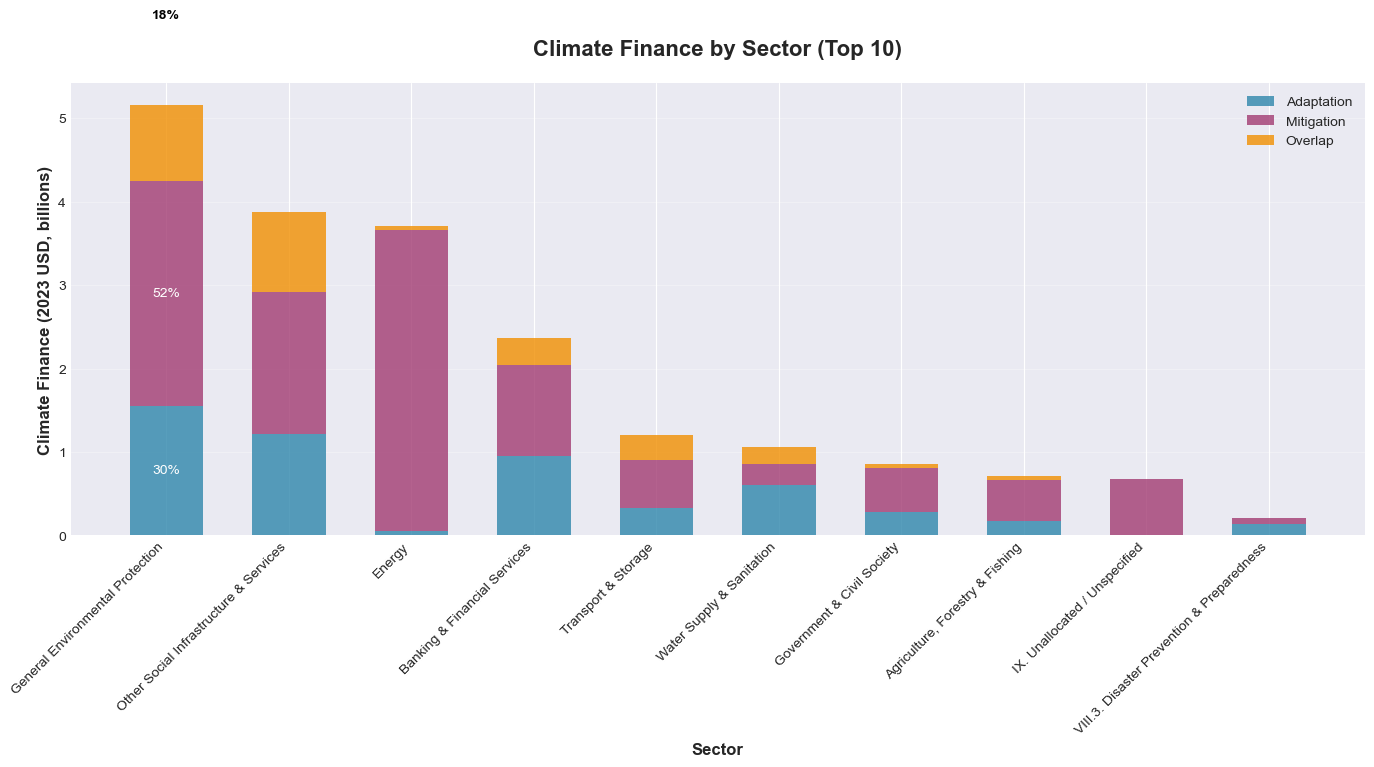


Top 10 Sectors (billions USD):
                                            Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Sector                                                                                                                                   
General Environmental Protection                                                         1.55                                            
Other Social Infrastructure & Services                                                   1.22                                            
Energy                                                                                   0.05                                            
Banking & Financial Services                                                             0.96                                            
Transport & Storage                                                                      0.33                                            
Wa

<Figure size 640x480 with 0 Axes>


Top 10 Sectors (billions USD):
                                            Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Sector                                                                                                                                   
General Environmental Protection                                                         1.55                                            
Other Social Infrastructure & Services                                                   1.22                                            
Energy                                                                                   0.05                                            
Banking & Financial Services                                                             0.96                                            
Transport & Storage                                                                      0.33                                            
Wa

<Figure size 640x480 with 0 Axes>


Top 10 Sectors (billions USD):
                                            Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Sector                                                                                                                                   
General Environmental Protection                                                         1.55                                            
Other Social Infrastructure & Services                                                   1.22                                            
Energy                                                                                   0.05                                            
Banking & Financial Services                                                             0.96                                            
Transport & Storage                                                                      0.33                                            
Wa

<Figure size 640x480 with 0 Axes>


Top 10 Sectors (billions USD):
                                            Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Sector                                                                                                                                   
General Environmental Protection                                                         1.55                                            
Other Social Infrastructure & Services                                                   1.22                                            
Energy                                                                                   0.05                                            
Banking & Financial Services                                                             0.96                                            
Transport & Storage                                                                      0.33                                            
Wa

<Figure size 640x480 with 0 Axes>


Top 10 Sectors (billions USD):
                                            Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Sector                                                                                                                                   
General Environmental Protection                                                         1.55                                            
Other Social Infrastructure & Services                                                   1.22                                            
Energy                                                                                   0.05                                            
Banking & Financial Services                                                             0.96                                            
Transport & Storage                                                                      0.33                                            
Wa

<Figure size 640x480 with 0 Axes>


Top 10 Sectors (billions USD):
                                            Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Sector                                                                                                                                   
General Environmental Protection                                                         1.55                                            
Other Social Infrastructure & Services                                                   1.22                                            
Energy                                                                                   0.05                                            
Banking & Financial Services                                                             0.96                                            
Transport & Storage                                                                      0.33                                            
Wa

<Figure size 640x480 with 0 Axes>


Top 10 Sectors (billions USD):
                                            Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Sector                                                                                                                                   
General Environmental Protection                                                         1.55                                            
Other Social Infrastructure & Services                                                   1.22                                            
Energy                                                                                   0.05                                            
Banking & Financial Services                                                             0.96                                            
Transport & Storage                                                                      0.33                                            
Wa

<Figure size 640x480 with 0 Axes>


Top 10 Sectors (billions USD):
                                            Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Sector                                                                                                                                   
General Environmental Protection                                                         1.55                                            
Other Social Infrastructure & Services                                                   1.22                                            
Energy                                                                                   0.05                                            
Banking & Financial Services                                                             0.96                                            
Transport & Storage                                                                      0.33                                            
Wa

<Figure size 640x480 with 0 Axes>


Top 10 Sectors (billions USD):
                                            Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Sector                                                                                                                                   
General Environmental Protection                                                         1.55                                            
Other Social Infrastructure & Services                                                   1.22                                            
Energy                                                                                   0.05                                            
Banking & Financial Services                                                             0.96                                            
Transport & Storage                                                                      0.33                                            
Wa

<Figure size 640x480 with 0 Axes>


Top 10 Sectors (billions USD):
                                            Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Sector                                                                                                                                   
General Environmental Protection                                                         1.55                                            
Other Social Infrastructure & Services                                                   1.22                                            
Energy                                                                                   0.05                                            
Banking & Financial Services                                                             0.96                                            
Transport & Storage                                                                      0.33                                            
Wa

In [23]:
import matplotlib.pyplot as plt

if 'Sector' in df.columns:

    # Rename map for cleaner labels
    sector_rename_map = {
        "II.3. Energy": "Energy",
        "II.1. Transport & Storage": "Transport & Storage",
        "III.1. Agriculture, Forestry, Fishing": "Agriculture, Forestry & Fishing",
        "IV.1. General Environment Protection": "General Environmental Protection",
        "I.4. Water Supply & Sanitation": "Water Supply & Sanitation",
        "IV.2. Other Multisector": "Other Multisector",
        "II.4. Banking & Financial Services": "Banking & Financial Services",
        "I.5. Government & Civil Society": "Government & Civil Society",
        "I.6. Other Social Infrastructure & Services": "Other Social Infrastructure & Services",
        "I.2. Health": "Health"
    }

    # Aggregate by sector
    sector_finance = df.groupby('Sector').agg({
        adaptation_col: 'sum',
        mitigation_col: 'sum',
        overlap_col: 'sum'
    })

    # Rename labels
    sector_finance = sector_finance.rename(index=sector_rename_map)

    # Compute total
    sector_finance['Total'] = (
        sector_finance[adaptation_col]
        + sector_finance[mitigation_col]
        + sector_finance[overlap_col]
    )

    # Top 10
    sector_finance = sector_finance.sort_values('Total', ascending=False).head(10)

    # Convert to billions for plotting
    adapt_b = sector_finance[adaptation_col] / 1e6
    mitig_b = sector_finance[mitigation_col] / 1e6
    overlap_b = sector_finance[overlap_col] / 1e6
    total_b = sector_finance['Total'] / 1e6

    fig, ax = plt.subplots(figsize=(14, 8))
    x = range(len(sector_finance))
    width = 0.6

    # Bars
    ax.bar(x, adapt_b, width, label='Adaptation', color='#2E86AB', alpha=0.8)
    ax.bar(x, mitig_b, width, bottom=adapt_b, label='Mitigation', color='#A23B72', alpha=0.8)
    ax.bar(x, overlap_b, width, bottom=adapt_b + mitig_b, label='Overlap', color='#F18F01', alpha=0.8)

    # Add % labels inside each stacked segment
    # Add % labels (orange above bar, others inside)
for i in range(len(sector_finance)):
    if total_b.iloc[i] == 0:
        continue

    a_pct = 100 * (adapt_b.iloc[i] / total_b.iloc[i])
    m_pct = 100 * (mitig_b.iloc[i] / total_b.iloc[i])
    o_pct = 100 * (overlap_b.iloc[i] / total_b.iloc[i])

    min_pct_to_label = 4

    # Adaptation (inside, white)
    if a_pct >= min_pct_to_label and adapt_b.iloc[i] > 0:
        ax.text(
            i,
            adapt_b.iloc[i] / 2,
            f"{a_pct:.0f}%",
            ha='center',
            va='center',
            fontsize=10,
            color='white'
        )

    # Mitigation (inside, white)
    if m_pct >= min_pct_to_label and mitig_b.iloc[i] > 0:
        ax.text(
            i,
            adapt_b.iloc[i] + mitig_b.iloc[i] / 2,
            f"{m_pct:.0f}%",
            ha='center',
            va='center',
            fontsize=10,
            color='white'
        )

    # Overlap (ABOVE bar, black)
    if o_pct >= min_pct_to_label and overlap_b.iloc[i] > 0:
        ax.text(
            i,
            total_b.iloc[i] + 1.0,   # small vertical offset
            f"{o_pct:.0f}%",
            ha='center',
            va='bottom',
            fontsize=10,
            color='black',
            fontweight='bold'
        )


    ax.set_xlabel('Sector', fontsize=12, fontweight='bold')
    ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    ax.set_title('Climate Finance by Sector (Top 10)', fontsize=16, fontweight='bold', pad=20)

    ax.set_xticks(list(x))
    ax.set_xticklabels(sector_finance.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nTop 10 Sectors (billions USD):")
    print((sector_finance[[adaptation_col, mitigation_col, overlap_col]] / 1e6).round(2))

else:
    print("Column 'Sector' not found in df.")


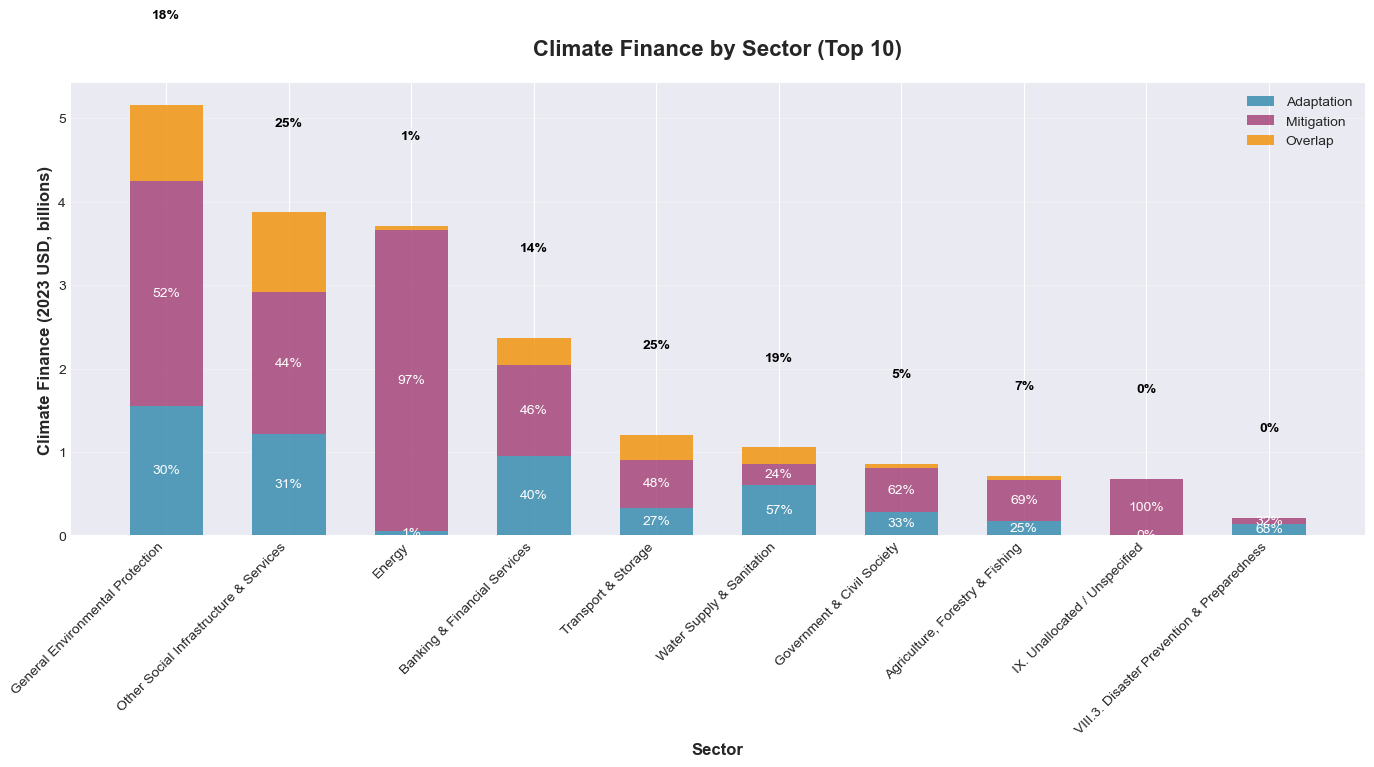


Top 10 Sectors (billions USD):
                                            Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Sector                                                                                                                                   
General Environmental Protection                                                         1.55                                            
Other Social Infrastructure & Services                                                   1.22                                            
Energy                                                                                   0.05                                            
Banking & Financial Services                                                             0.96                                            
Transport & Storage                                                                      0.33                                            
Wa

In [24]:
import matplotlib.pyplot as plt

if 'Sector' in df.columns:

    # Rename map for cleaner labels
    sector_rename_map = {
        "II.3. Energy": "Energy",
        "II.1. Transport & Storage": "Transport & Storage",
        "III.1. Agriculture, Forestry, Fishing": "Agriculture, Forestry & Fishing",
        "IV.1. General Environment Protection": "General Environmental Protection",
        "I.4. Water Supply & Sanitation": "Water Supply & Sanitation",
        "IV.2. Other Multisector": "Other Multisector",
        "II.4. Banking & Financial Services": "Banking & Financial Services",
        "I.5. Government & Civil Society": "Government & Civil Society",
        "I.6. Other Social Infrastructure & Services": "Other Social Infrastructure & Services",
        "I.2. Health": "Health"
    }

    # Aggregate by sector
    sector_finance = df.groupby('Sector').agg({
        adaptation_col: 'sum',
        mitigation_col: 'sum',
        overlap_col: 'sum'
    })

    # Rename labels
    sector_finance = sector_finance.rename(index=sector_rename_map)

    # Compute total
    sector_finance['Total'] = (
        sector_finance[adaptation_col]
        + sector_finance[mitigation_col]
        + sector_finance[overlap_col]
    )

    # Top 10
    sector_finance = sector_finance.sort_values('Total', ascending=False).head(10)

    # Convert to billions for plotting
    adapt_b = sector_finance[adaptation_col] / 1e6
    mitig_b = sector_finance[mitigation_col] / 1e6
    overlap_b = sector_finance[overlap_col] / 1e6
    total_b = sector_finance['Total'] / 1e6

    fig, ax = plt.subplots(figsize=(14, 8))
    x = range(len(sector_finance))
    width = 0.6

    # Bars
    ax.bar(x, adapt_b, width, label='Adaptation', color='#2E86AB', alpha=0.8)
    ax.bar(x, mitig_b, width, bottom=adapt_b, label='Mitigation', color='#A23B72', alpha=0.8)
    ax.bar(x, overlap_b, width, bottom=adapt_b + mitig_b, label='Overlap', color='#F18F01', alpha=0.8)

    # Add % labels (orange above bar in black; others inside in white)
    for i in range(len(sector_finance)):
        if total_b.iloc[i] == 0:
            continue

        a_pct = 100 * (adapt_b.iloc[i] / total_b.iloc[i])
        m_pct = 100 * (mitig_b.iloc[i] / total_b.iloc[i])
        o_pct = 100 * (overlap_b.iloc[i] / total_b.iloc[i])

        min_pct_to_label = 0

        # Adaptation (inside, white)
        if a_pct >= min_pct_to_label and adapt_b.iloc[i] > 0:
            ax.text(
                i,
                adapt_b.iloc[i] / 2,
                f"{a_pct:.0f}%",
                ha='center',
                va='center',
                fontsize=10,
                color='white'
            )

        # Mitigation (inside, white)
        if m_pct >= min_pct_to_label and mitig_b.iloc[i] > 0:
            ax.text(
                i,
                adapt_b.iloc[i] + mitig_b.iloc[i] / 2,
                f"{m_pct:.0f}%",
                ha='center',
                va='center',
                fontsize=10,
                color='white'
            )

        # Overlap (ABOVE bar, black)
        if o_pct >= min_pct_to_label and overlap_b.iloc[i] > 0:
            ax.text(
                i,
                total_b.iloc[i] + 1.0,   # vertical offset above the bar
                f"{o_pct:.0f}%",
                ha='center',
                va='bottom',
                fontsize=10,
                color='black',
                fontweight='bold'
            )

    ax.set_xlabel('Sector', fontsize=12, fontweight='bold')
    ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    ax.set_title('Climate Finance by Sector (Top 10)', fontsize=16, fontweight='bold', pad=20)

    ax.set_xticks(list(x))
    ax.set_xticklabels(sector_finance.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nTop 10 Sectors (billions USD):")
    print((sector_finance[[adaptation_col, mitigation_col, overlap_col]] / 1e6).round(2))

else:
    print("Column 'Sector' not found in df.")


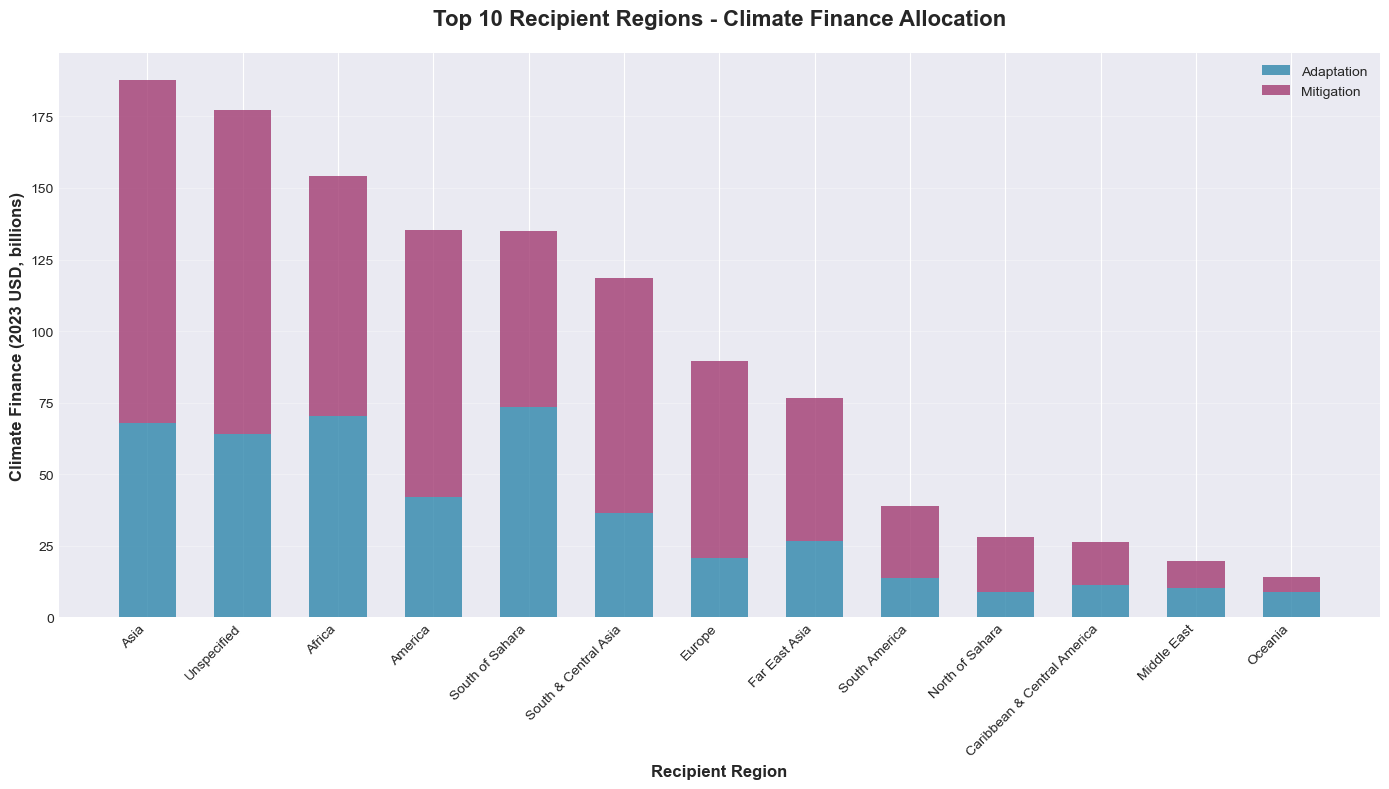


Top 10 Recipient Regions (billions USD):
                             Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Recipient Region                                                                                                          
Asia                                                                     68.04                                            
Unspecified                                                              64.11                                            
Africa                                                                   70.26                                            
America                                                                  42.01                                            
South of Sahara                                                          73.40                                            
South & Central Asia                                                     36.34                   

In [28]:
import matplotlib.pyplot as plt

if 'Recipient Region' in df.columns:

    # Aggregate by recipient region
    region_finance = df.groupby('Recipient Region').agg({
        adaptation_col: 'sum',
        mitigation_col: 'sum'
    })

    # Compute total
    region_finance['Total'] = (
        region_finance[adaptation_col] + region_finance[mitigation_col]
    )

    # Top 10 by total
    region_finance = region_finance.sort_values('Total', ascending=False)

    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 8))

    x = range(len(region_finance))
    width = 0.6

    # Same colors as before
    p1 = ax.bar(
        x,
        region_finance[adaptation_col] / 1e6,
        width,
        label='Adaptation',
        color='#2E86AB',   # Blue
        alpha=0.8
    )

    p2 = ax.bar(
        x,
        region_finance[mitigation_col] / 1e6,
        width,
        bottom=region_finance[adaptation_col] / 1e6,
        label='Mitigation',
        color='#A23B72',   # Pink
        alpha=0.8
    )

    ax.set_xlabel('Recipient Region', fontsize=12, fontweight='bold')
    ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    ax.set_title(
        'Top 10 Recipient Regions - Climate Finance Allocation',
        fontsize=16,
        fontweight='bold',
        pad=20
    )

    ax.set_xticks(list(x))
    ax.set_xticklabels(region_finance.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nTop 10 Recipient Regions (billions USD):")
    print((region_finance[[adaptation_col, mitigation_col]] / 1e6).round(2))

else:
    print("Column 'Recipient Region' not found in df.")


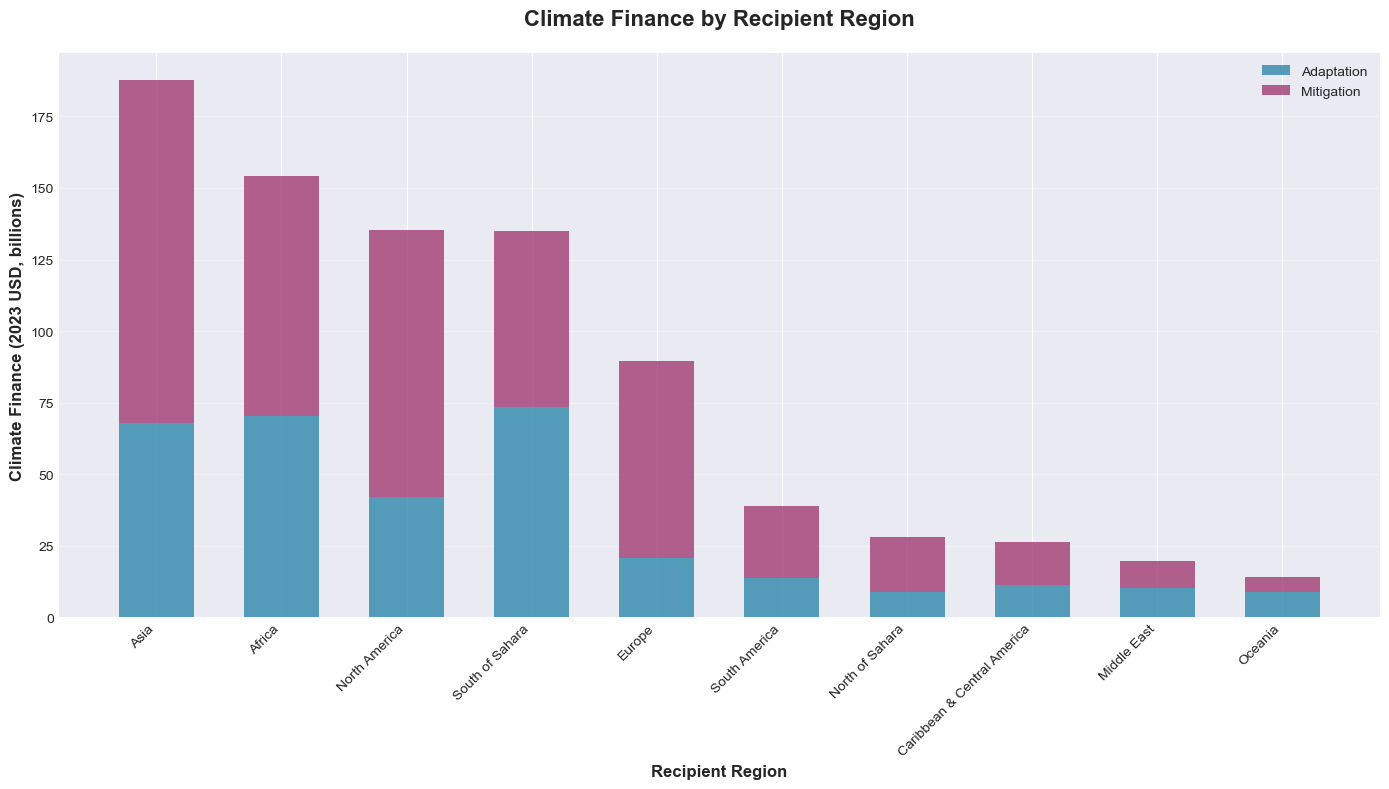


Recipient Regions (billions USD):
                             Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Recipient Region                                                                                                          
Asia                                                                     68.04                                            
Africa                                                                   70.26                                            
North America                                                            42.01                                            
South of Sahara                                                          73.40                                            
Europe                                                                   20.70                                            
South America                                                            13.95                          

In [30]:
import matplotlib.pyplot as plt

if 'Recipient Region' in df.columns:

    # Regions to remove
    exclude_regions = [
        'Unspecified',
        'South & Central Asia',
        'Far East Asia'
    ]

    # Rename map
    region_rename_map = {
        'America': 'North America'
    }

    # Clean region column
    df_clean = df.copy()

    # Remove unwanted regions
    df_clean = df_clean[~df_clean['Recipient Region'].isin(exclude_regions)]

    # Rename regions
    df_clean['Recipient Region'] = df_clean['Recipient Region'].replace(region_rename_map)

    # Aggregate by region
    region_finance = df_clean.groupby('Recipient Region').agg({
        adaptation_col: 'sum',
        mitigation_col: 'sum'
    })

    # Compute total
    region_finance['Total'] = (
        region_finance[adaptation_col] + region_finance[mitigation_col]
    )

    # Sort (keep all regions, or add .head(10) if needed)
    region_finance = region_finance.sort_values('Total', ascending=False)

    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 8))

    x = range(len(region_finance))
    width = 0.6

    # Same colors as before
    p1 = ax.bar(
        x,
        region_finance[adaptation_col] / 1e6,
        width,
        label='Adaptation',
        color='#2E86AB',
        alpha=0.8
    )

    p2 = ax.bar(
        x,
        region_finance[mitigation_col] / 1e6,
        width,
        bottom=region_finance[adaptation_col] / 1e6,
        label='Mitigation',
        color='#A23B72',
        alpha=0.8
    )

    ax.set_xlabel('Recipient Region', fontsize=12, fontweight='bold')
    ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    ax.set_title(
        'Climate Finance by Recipient Region',
        fontsize=16,
        fontweight='bold',
        pad=20
    )

    ax.set_xticks(list(x))
    ax.set_xticklabels(region_finance.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print values
    print("\nRecipient Regions (billions USD):")
    print((region_finance[[adaptation_col, mitigation_col]] / 1e6).round(2))

else:
    print("Column 'Recipient Region' not found in df.")


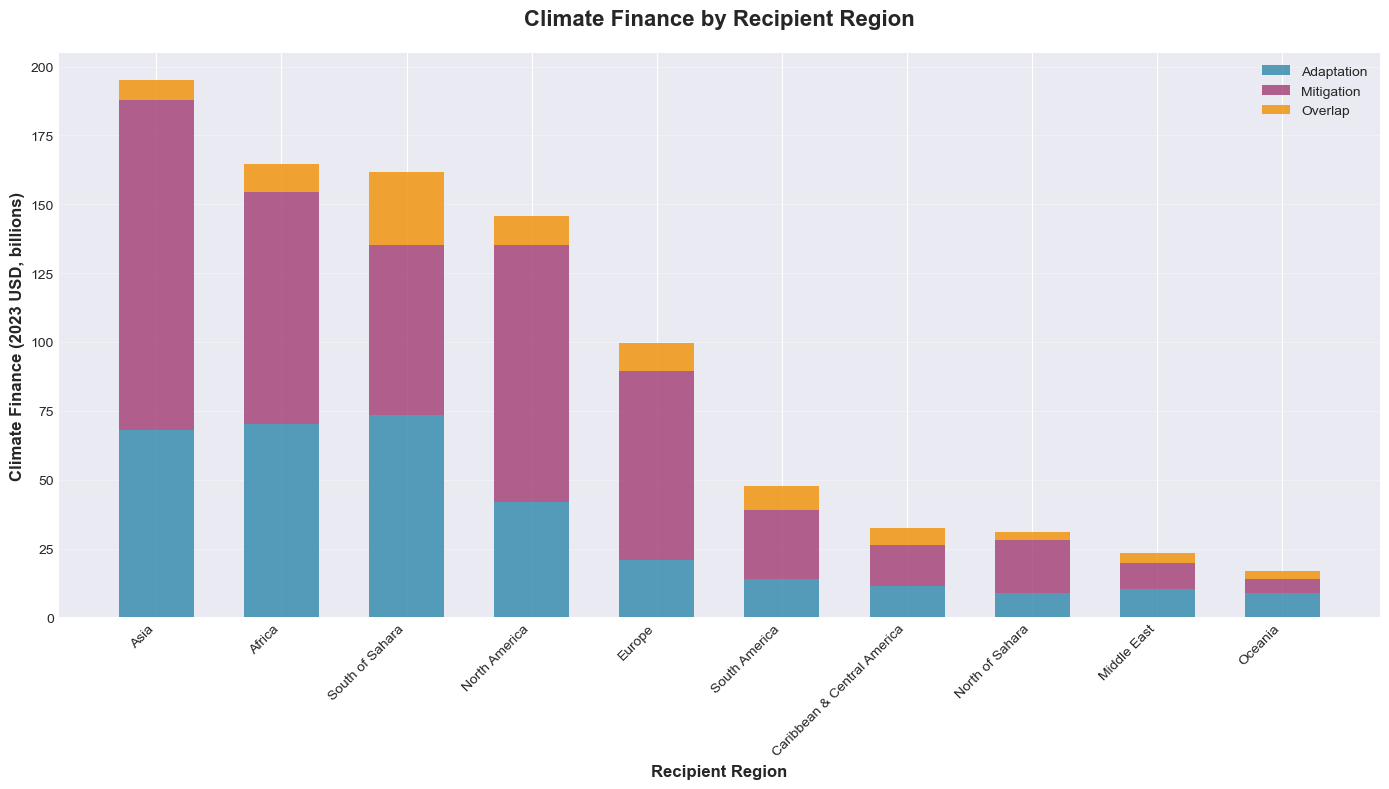


Recipient Regions (billions USD):
                             Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Recipient Region                                                                                                          
Asia                                                                     68.04                                            
Africa                                                                   70.26                                            
South of Sahara                                                          73.40                                            
North America                                                            42.01                                            
Europe                                                                   20.70                                            
South America                                                            13.95                          

In [32]:
import matplotlib.pyplot as plt

if 'Recipient Region' in df.columns:

    # Regions to remove
    exclude_regions = [
        'Unspecified',
        'South & Central Asia',
        'Far East Asia'
    ]

    # Rename map
    region_rename_map = {
        'America': 'North America'
    }

    # Clean region column
    df_clean = df.copy()

    # Remove unwanted regions
    df_clean = df_clean[~df_clean['Recipient Region'].isin(exclude_regions)]

    # Rename regions
    df_clean['Recipient Region'] = df_clean['Recipient Region'].replace(region_rename_map)

    # Aggregate by region (ADD overlap here)
    region_finance = df_clean.groupby('Recipient Region').agg({
        adaptation_col: 'sum',
        mitigation_col: 'sum',
        overlap_col: 'sum'
    })

    # Compute total (INCLUDE overlap)
    region_finance['Total'] = (
        region_finance[adaptation_col]
        + region_finance[mitigation_col]
        + region_finance[overlap_col]
    )

    # Sort
    region_finance = region_finance.sort_values('Total', ascending=False)

    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 8))

    x = range(len(region_finance))
    width = 0.6

    # Adaptation
    ax.bar(
        x,
        region_finance[adaptation_col] / 1e6,
        width,
        label='Adaptation',
        color='#2E86AB',
        alpha=0.8
    )

    # Mitigation
    ax.bar(
        x,
        region_finance[mitigation_col] / 1e6,
        width,
        bottom=region_finance[adaptation_col] / 1e6,
        label='Mitigation',
        color='#A23B72',
        alpha=0.8
    )

    # Overlap (NEW)
    ax.bar(
        x,
        region_finance[overlap_col] / 1e6,
        width,
        bottom=(
            region_finance[adaptation_col]
            + region_finance[mitigation_col]
        ) / 1e6,
        label='Overlap',
        color='#F18F01',   # Orange
        alpha=0.8
    )

    ax.set_xlabel('Recipient Region', fontsize=12, fontweight='bold')
    ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    ax.set_title(
        'Climate Finance by Recipient Region',
        fontsize=16,
        fontweight='bold',
        pad=20
    )

    ax.set_xticks(list(x))
    ax.set_xticklabels(region_finance.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print values (ADD overlap)
    print("\nRecipient Regions (billions USD):")
    print(
        (region_finance[
            [adaptation_col, mitigation_col, overlap_col]
        ] / 1e6).round(2)
    )

else:
    print("Column 'Recipient Region' not found in df.")


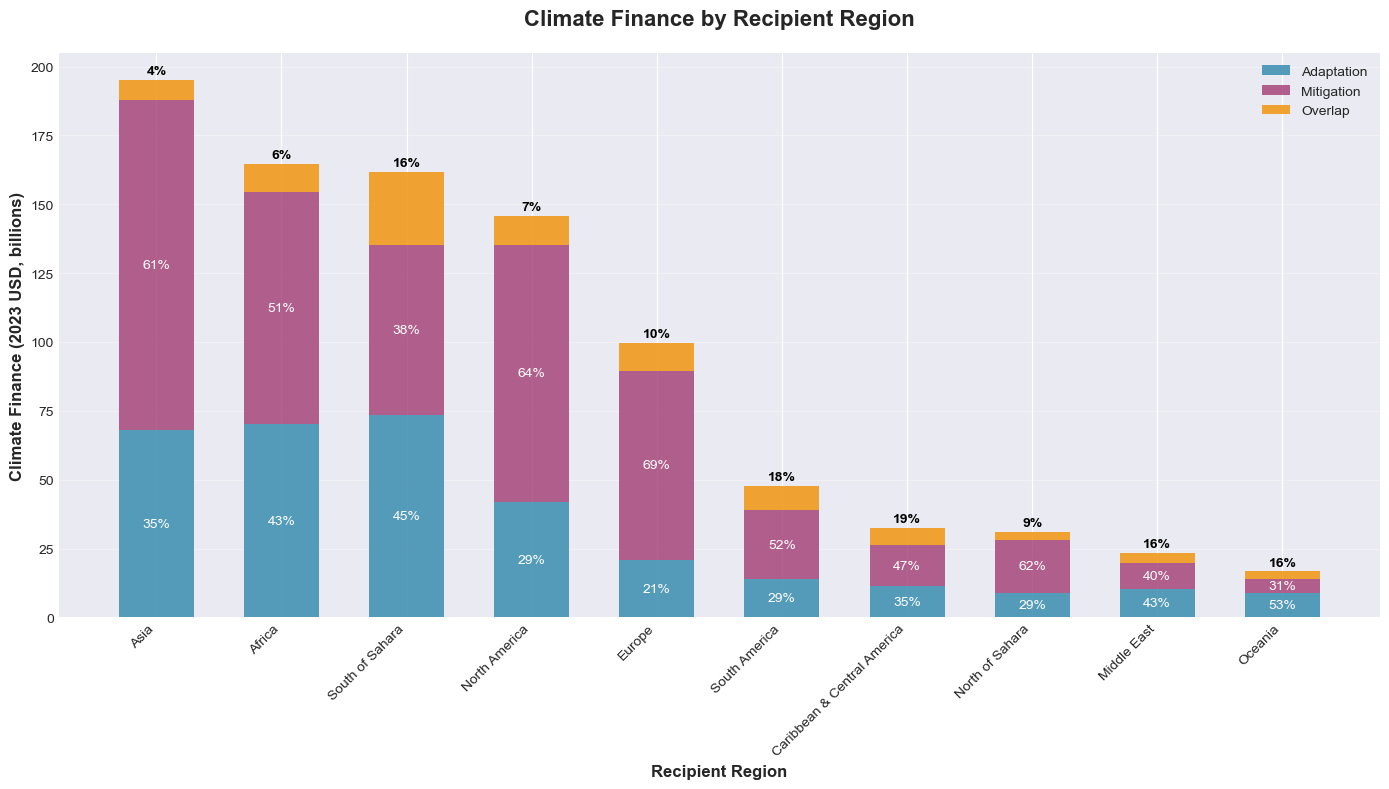


Recipient Regions (billions USD):
                             Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Recipient Region                                                                                                          
Asia                                                                     68.04                                            
Africa                                                                   70.26                                            
South of Sahara                                                          73.40                                            
North America                                                            42.01                                            
Europe                                                                   20.70                                            
South America                                                            13.95                          

In [40]:
import matplotlib.pyplot as plt

if 'Recipient Region' in df.columns:

    # Regions to remove
    exclude_regions = [
        'Unspecified',
        'South & Central Asia',
        'Far East Asia'
    ]

    # Rename map
    region_rename_map = {
        'America': 'North America'
    }

    # Clean region column
    df_clean = df.copy()

    # Remove unwanted regions
    df_clean = df_clean[~df_clean['Recipient Region'].isin(exclude_regions)]

    # Rename regions
    df_clean['Recipient Region'] = df_clean['Recipient Region'].replace(region_rename_map)

    # Aggregate by region (ADD overlap here)
    region_finance = df_clean.groupby('Recipient Region').agg({
        adaptation_col: 'sum',
        mitigation_col: 'sum',
        overlap_col: 'sum'
    })

    # Compute total (INCLUDE overlap)
    region_finance['Total'] = (
        region_finance[adaptation_col]
        + region_finance[mitigation_col]
        + region_finance[overlap_col]
    )

    # Sort
    region_finance = region_finance.sort_values('Total', ascending=False)

    # Convert to billions for plotting/labels
    adapt_b = region_finance[adaptation_col] / 1e6
    mitig_b = region_finance[mitigation_col] / 1e6
    overlap_b = region_finance[overlap_col] / 1e6
    total_b = region_finance['Total'] / 1e6

    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 8))

    x = range(len(region_finance))
    width = 0.6

    # Adaptation
    ax.bar(
        x,
        adapt_b,
        width,
        label='Adaptation',
        color='#2E86AB',
        alpha=0.8
    )

    # Mitigation
    ax.bar(
        x,
        mitig_b,
        width,
        bottom=adapt_b,
        label='Mitigation',
        color='#A23B72',
        alpha=0.8
    )

    # Overlap
    ax.bar(
        x,
        overlap_b,
        width,
        bottom=(adapt_b + mitig_b),
        label='Overlap',
        color='#F18F01',   # Orange
        alpha=0.8
    )

    # Add % labels (orange ALWAYS shown above bar in black; others inside if big enough)
    min_pct_main = 4

    for i in range(len(region_finance)):
        if total_b.iloc[i] == 0:
            continue

        a_pct = 100 * (adapt_b.iloc[i] / total_b.iloc[i])
        m_pct = 100 * (mitig_b.iloc[i] / total_b.iloc[i])
        o_pct = 100 * (overlap_b.iloc[i] / total_b.iloc[i])

        # Adaptation (inside, white)
        if a_pct >= min_pct_main and adapt_b.iloc[i] > 0:
            ax.text(
                i,
                adapt_b.iloc[i] / 2,
                f"{a_pct:.0f}%",
                ha='center',
                va='center',
                fontsize=10,
                color='white'
            )

        # Mitigation (inside, white)
        if m_pct >= min_pct_main and mitig_b.iloc[i] > 0:
            ax.text(
                i,
                adapt_b.iloc[i] + mitig_b.iloc[i] / 2,
                f"{m_pct:.0f}%",
                ha='center',
                va='center',
                fontsize=10,
                color='white'
            )

        # Overlap (ALWAYS show, above bar, black)
        if overlap_b.iloc[i] > 0:
            ax.text(
                i,
                total_b.iloc[i] + 1.0,   # vertical offset above the bar
                f"{o_pct:.0f}%",
                ha='center',
                va='bottom',
                fontsize=10,
                color='black',
                fontweight='bold'
            )

    ax.set_xlabel('Recipient Region', fontsize=12, fontweight='bold')
    ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    ax.set_title(
        'Climate Finance by Recipient Region',
        fontsize=16,
        fontweight='bold',
        pad=20
    )

    ax.set_xticks(list(x))
    ax.set_xticklabels(region_finance.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print values (ADD overlap)
    print("\nRecipient Regions (billions USD):")
    print(
        (region_finance[
            [adaptation_col, mitigation_col, overlap_col]
        ] / 1e6).round(2)
    )

else:
    print("Column 'Recipient Region' not found in df.")


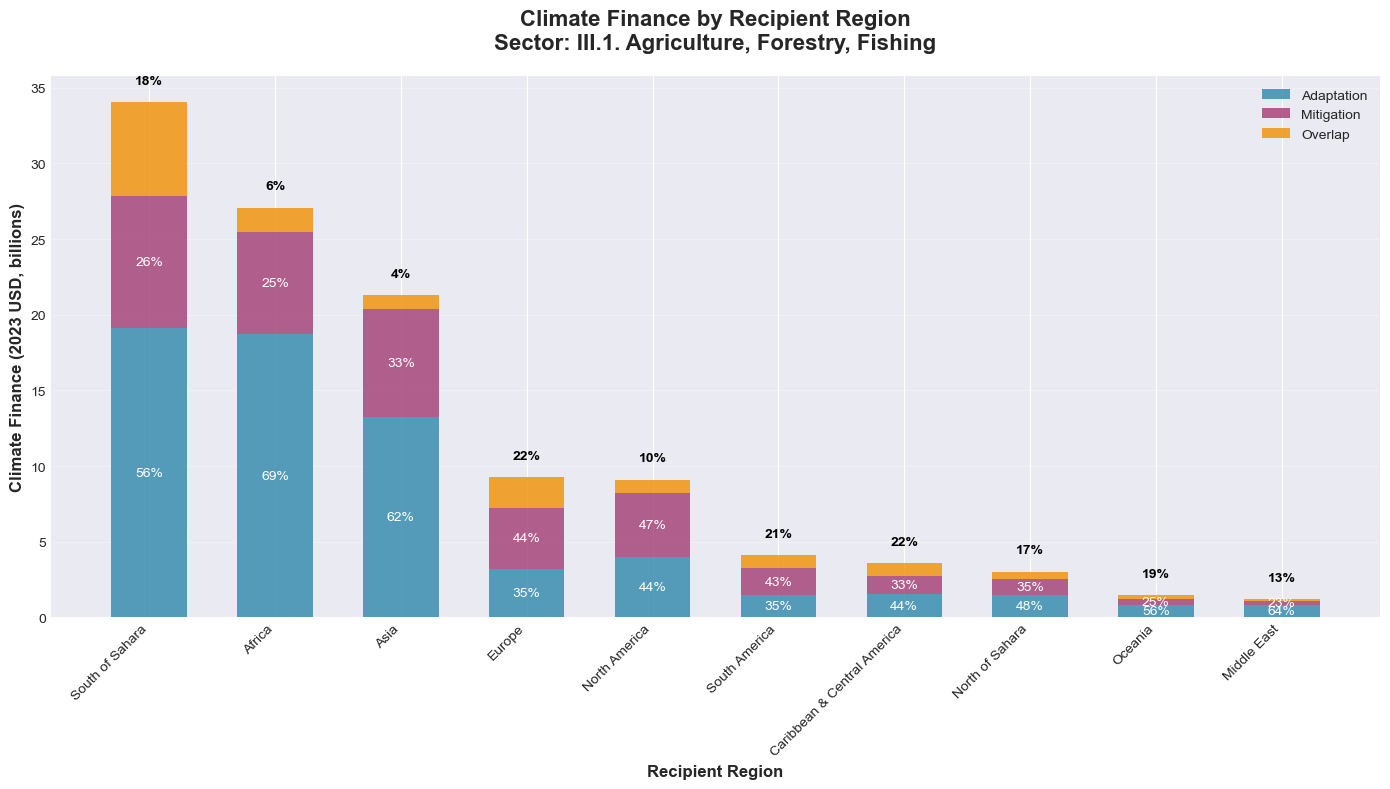


Recipient Regions (billions USD) — Sector: III.1. Agriculture, Forestry, Fishing
                             Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Recipient Region                                                                                                          
South of Sahara                                                          19.11                                            
Africa                                                                   18.70                                            
Asia                                                                     13.24                                            
Europe                                                                    3.21                                            
North America                                                             3.97                                            
South America                                            

In [41]:
import matplotlib.pyplot as plt

# --- filter to JUST this sector ---
target_sector = "III.1. Agriculture, Forestry, Fishing"

if 'Sector' not in df.columns:
    print("Column 'Sector' not found in df.")
elif 'Recipient Region' not in df.columns:
    print("Column 'Recipient Region' not found in df.")
else:
    # Filter to the sector (strip handles accidental whitespace)
    df_sector = df[df['Sector'].astype(str).str.strip() == target_sector].copy()

    if df_sector.empty:
        print(f"No rows found for Sector = {target_sector!r}")
    else:
        # Regions to remove
        exclude_regions = [
            'Unspecified',
            'South & Central Asia',
            'Far East Asia'
        ]

        # Rename map
        region_rename_map = {
            'America': 'North America'
        }

        # Clean region column
        df_clean = df_sector.copy()

        # Remove unwanted regions
        df_clean = df_clean[~df_clean['Recipient Region'].isin(exclude_regions)]

        # Rename regions
        df_clean['Recipient Region'] = df_clean['Recipient Region'].replace(region_rename_map)

        # Aggregate by region (ADD overlap here)
        region_finance = df_clean.groupby('Recipient Region').agg({
            adaptation_col: 'sum',
            mitigation_col: 'sum',
            overlap_col: 'sum'
        })

        # Compute total (INCLUDE overlap)
        region_finance['Total'] = (
            region_finance[adaptation_col]
            + region_finance[mitigation_col]
            + region_finance[overlap_col]
        )

        # Sort
        region_finance = region_finance.sort_values('Total', ascending=False)

        # Convert to billions for plotting/labels
        adapt_b = region_finance[adaptation_col] / 1e6
        mitig_b = region_finance[mitigation_col] / 1e6
        overlap_b = region_finance[overlap_col] / 1e6
        total_b = region_finance['Total'] / 1e6

        # Create stacked bar chart
        fig, ax = plt.subplots(figsize=(14, 8))

        x = range(len(region_finance))
        width = 0.6

        # Adaptation
        ax.bar(
            x,
            adapt_b,
            width,
            label='Adaptation',
            color='#2E86AB',
            alpha=0.8
        )

        # Mitigation
        ax.bar(
            x,
            mitig_b,
            width,
            bottom=adapt_b,
            label='Mitigation',
            color='#A23B72',
            alpha=0.8
        )

        # Overlap
        ax.bar(
            x,
            overlap_b,
            width,
            bottom=(adapt_b + mitig_b),
            label='Overlap',
            color='#F18F01',
            alpha=0.8
        )

        # Add % labels (orange ALWAYS above bar; others inside if big enough)
        min_pct_main = 4

        for i in range(len(region_finance)):
            if total_b.iloc[i] == 0:
                continue

            a_pct = 100 * (adapt_b.iloc[i] / total_b.iloc[i])
            m_pct = 100 * (mitig_b.iloc[i] / total_b.iloc[i])
            o_pct = 100 * (overlap_b.iloc[i] / total_b.iloc[i])

            # Adaptation (inside, white)
            if a_pct >= min_pct_main and adapt_b.iloc[i] > 0:
                ax.text(
                    i,
                    adapt_b.iloc[i] / 2,
                    f"{a_pct:.0f}%",
                    ha='center',
                    va='center',
                    fontsize=10,
                    color='white'
                )

            # Mitigation (inside, white)
            if m_pct >= min_pct_main and mitig_b.iloc[i] > 0:
                ax.text(
                    i,
                    adapt_b.iloc[i] + mitig_b.iloc[i] / 2,
                    f"{m_pct:.0f}%",
                    ha='center',
                    va='center',
                    fontsize=10,
                    color='white'
                )

            # Overlap (ALWAYS show, above bar, black)
            if overlap_b.iloc[i] > 0:
                ax.text(
                    i,
                    total_b.iloc[i] + 1.0,   # vertical offset above the bar
                    f"{o_pct:.0f}%",
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    color='black',
                    fontweight='bold'
                )

        ax.set_xlabel('Recipient Region', fontsize=12, fontweight='bold')
        ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
        ax.set_title(
            f'Climate Finance by Recipient Region\nSector: {target_sector}',
            fontsize=16,
            fontweight='bold',
            pad=20
        )

        ax.set_xticks(list(x))
        ax.set_xticklabels(region_finance.index, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print values (ADD overlap)
        print(f"\nRecipient Regions (billions USD) — Sector: {target_sector}")
        print(
            (region_finance[[adaptation_col, mitigation_col, overlap_col]] / 1e6).round(2)
        )


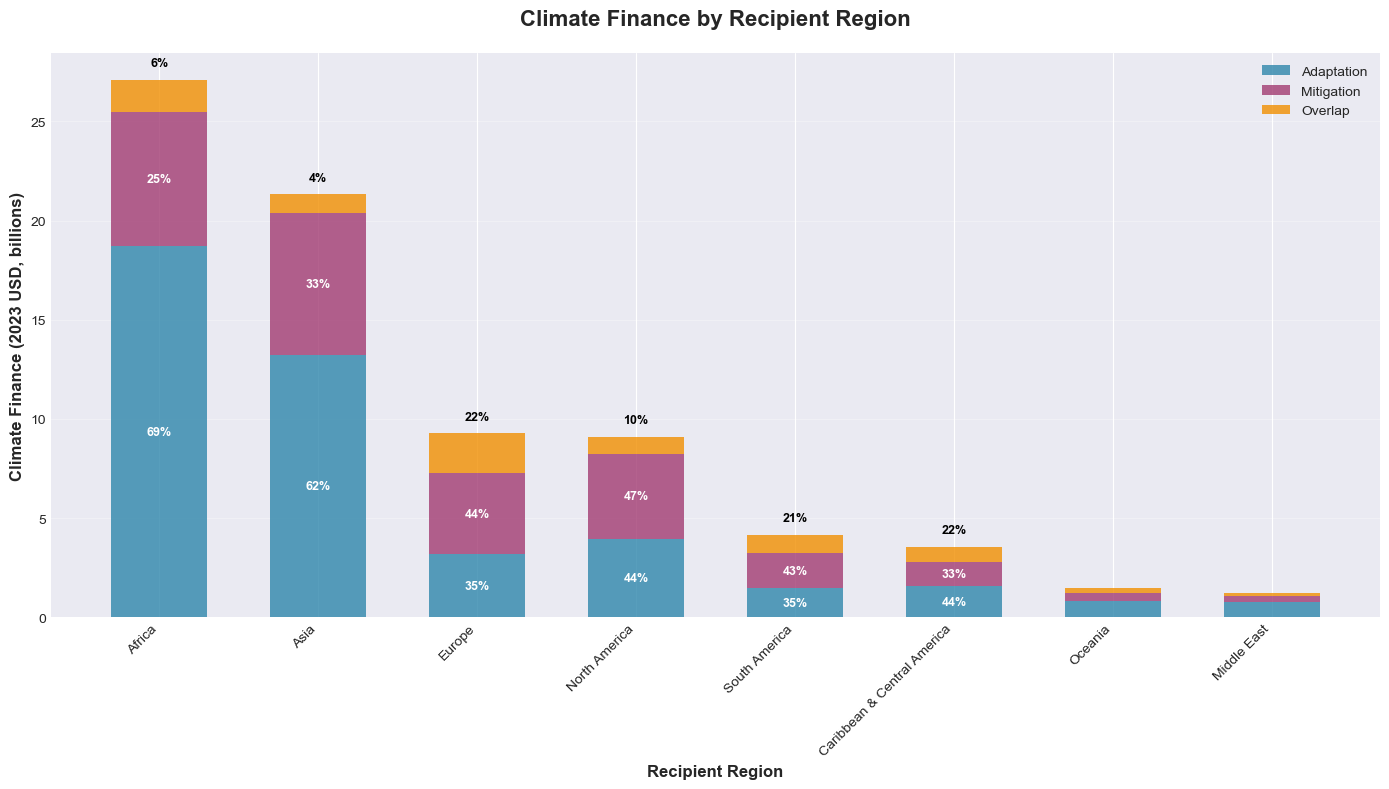


Recipient Regions (billions USD) — Sector: III.1. Agriculture, Forestry, Fishing
                             Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Recipient Region                                                                                                          
Africa                                                                   18.70                                            
Asia                                                                     13.24                                            
Europe                                                                    3.21                                            
North America                                                             3.97                                            
South America                                                             1.46                                            
Caribbean & Central America                              

In [55]:
import matplotlib.pyplot as plt

# --- filter to JUST this sector ---
target_sector = "III.1. Agriculture, Forestry, Fishing"

if 'Sector' not in df.columns:
    print("Column 'Sector' not found in df.")
elif 'Recipient Region' not in df.columns:
    print("Column 'Recipient Region' not found in df.")
else:
    # Filter to the sector (strip handles accidental whitespace)
    df_sector = df[df['Sector'].astype(str).str.strip() == target_sector].copy()

    if df_sector.empty:
        print(f"No rows found for Sector = {target_sector!r}")
    else:
        # Regions to remove
        exclude_regions = [
            'Unspecified',
            'South & Central Asia',
            'Far East Asia',
            'South of Sahara',
            'North of Sahara'
        ]

        # Rename map
        region_rename_map = {
            'America': 'North America'
        }

        # Clean region column
        df_clean = df_sector.copy()

        # Remove unwanted regions
        df_clean = df_clean[~df_clean['Recipient Region'].isin(exclude_regions)]

        # Rename regions
        df_clean['Recipient Region'] = df_clean['Recipient Region'].replace(region_rename_map)

        # Aggregate by region (ADD overlap here)
        region_finance = df_clean.groupby('Recipient Region').agg({
            adaptation_col: 'sum',
            mitigation_col: 'sum',
            overlap_col: 'sum'
        })

        # Compute total (INCLUDE overlap)
        region_finance['Total'] = (
            region_finance[adaptation_col]
            + region_finance[mitigation_col]
            + region_finance[overlap_col]
        )

        # Sort
        region_finance = (region_finance.sort_values('Total', ascending=False).head(8))

        # Convert to billions for plotting/labels
        adapt_b = region_finance[adaptation_col] / 1e6
        mitig_b = region_finance[mitigation_col] / 1e6
        overlap_b = region_finance[overlap_col] / 1e6
        total_b = region_finance['Total'] / 1e6

        # Create stacked bar chart
        fig, ax = plt.subplots(figsize=(14, 8))

        x = range(len(region_finance))
        width = 0.6

        # Adaptation
        ax.bar(
            x,
            adapt_b,
            width,
            label='Adaptation',
            color='#2E86AB',
            alpha=0.8
        )

        # Mitigation
        ax.bar(
            x,
            mitig_b,
            width,
            bottom=adapt_b,
            label='Mitigation',
            color='#A23B72',
            alpha=0.8
        )

        # Overlap
        ax.bar(
            x,
            overlap_b,
            width,
            bottom=(adapt_b + mitig_b),
            label='Overlap',
            color='#F18F01',
            alpha=0.8
        )

        # ---------------------------
        # Improved % labels (cleaner)
        # ---------------------------
        min_pct_inside = 2     # only label inside if >= 7%
        min_pct_overlap = 2    # only label overlap if >= 5%
        min_total_b = 2        # skip labeling if the whole bar is tiny (in billions)

        # Dynamic vertical offset for overlap labels (scales with bar height)
        offset = max(0.2, 0.02 * total_b.max())

        for i in range(len(region_finance)):
            t = total_b.iloc[i]
            if t <= 0 or t < min_total_b:
                continue

            a = adapt_b.iloc[i]
            m = mitig_b.iloc[i]
            o = overlap_b.iloc[i]

            a_pct = 100 * a / t if t else 0
            m_pct = 100 * m / t if t else 0
            o_pct = 100 * o / t if t else 0

            # Adaptation (inside, centered)
            if a > 0 and a_pct >= min_pct_inside:
                ax.text(
                    i,
                    a / 2,
                    f"{a_pct:.0f}%",
                    ha='center',
                    va='center',
                    fontsize=9,
                    color='white',
                    fontweight='bold'
                )

            # Mitigation (inside, centered)
            if m > 0 and m_pct >= min_pct_inside:
                ax.text(
                    i,
                    a + m / 2,
                    f"{m_pct:.0f}%",
                    ha='center',
                    va='center',
                    fontsize=9,
                    color='white',
                    fontweight='bold'
                )

            # Overlap (above bar, only if meaningful)
            if o > 0 and o_pct >= min_pct_overlap:
                ax.text(
                    i,
                    t + offset,
                    f"{o_pct:.0f}%",
                    ha='center',
                    va='bottom',
                    fontsize=9,
                    color='black',
                    fontweight='bold'
                )

        ax.set_xlabel('Recipient Region', fontsize=12, fontweight='bold')
        ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
        ax.set_title(
            f'Climate Finance by Recipient Region',
            fontsize=16,
            fontweight='bold',
            pad=20
        )

        ax.set_xticks(list(x))
        ax.set_xticklabels(region_finance.index, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print values (ADD overlap)
        print(f"\nRecipient Regions (billions USD) — Sector: {target_sector}")
        print(
            (region_finance[[adaptation_col, mitigation_col, overlap_col]] / 1e6).round(2)
        )


In [43]:
# Better labeling thresholds
min_pct_main = 7      # only label inside if >=7%
min_total = 2         # skip tiny total bars

for i in range(len(region_finance)):

    if total_b.iloc[i] < min_total:
        continue

    a = adapt_b.iloc[i]
    m = mitig_b.iloc[i]
    o = overlap_b.iloc[i]
    t = total_b.iloc[i]

    a_pct = 100 * a / t
    m_pct = 100 * m / t
    o_pct = 100 * o / t

    # --- Adaptation (centered) ---
    if a_pct >= min_pct_main:
        ax.text(
            i,
            a / 2,
            f"{a_pct:.0f}%",
            ha='center',
            va='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )

    # --- Mitigation (centered) ---
    if m_pct >= min_pct_main:
        ax.text(
            i,
            a + m / 2,
            f"{m_pct:.0f}%",
            ha='center',
            va='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )

    # --- Overlap (above bar) ---
    if o_pct >= 5:
        ax.text(
            i,
            t + 0.5,
            f"{o_pct:.0f}%",
            ha='center',
            va='bottom',
            fontsize=9,
            color='black',
            fontweight='bold'
        )

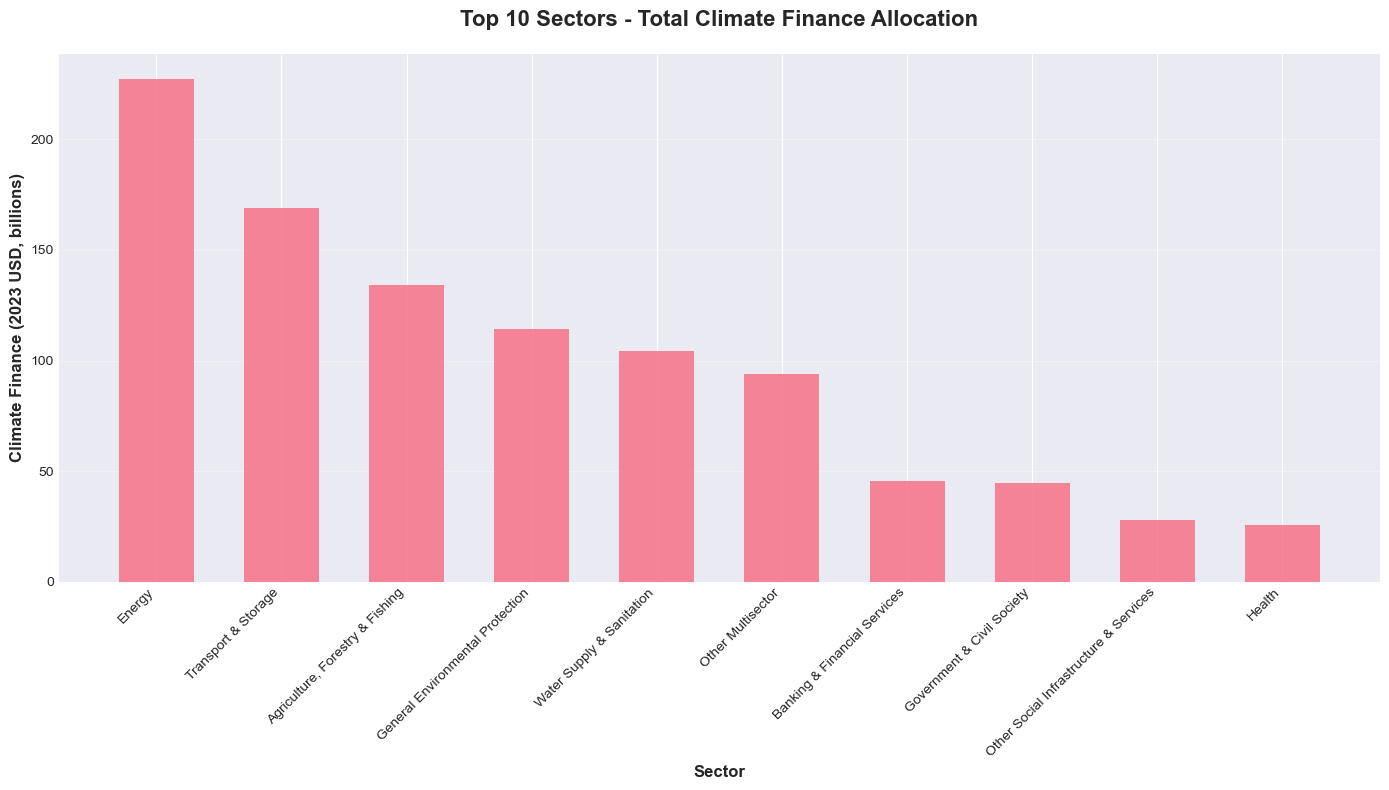


Top 10 Sectors (Total, billions USD):
Sector
Energy                                    227.25
Transport & Storage                       168.73
Agriculture, Forestry & Fishing           134.05
General Environmental Protection          114.47
Water Supply & Sanitation                 104.12
Other Multisector                          94.00
Banking & Financial Services               45.71
Government & Civil Society                 44.64
Other Social Infrastructure & Services     27.79
Health                                     25.72
Name: Total, dtype: float64


In [23]:
import matplotlib.pyplot as plt

if 'Sector' in df.columns:

    # Rename map for cleaner labels
    sector_rename_map = {
        "II.3. Energy": "Energy",
        "II.1. Transport & Storage": "Transport & Storage",
        "III.1. Agriculture, Forestry, Fishing": "Agriculture, Forestry & Fishing",
        "IV.1. General Environment Protection": "General Environmental Protection",
        "I.4. Water Supply & Sanitation": "Water Supply & Sanitation",
        "IV.2. Other Multisector": "Other Multisector",
        "II.4. Banking & Financial Services": "Banking & Financial Services",
        "I.5. Government & Civil Society": "Government & Civil Society",
        "I.6. Other Social Infrastructure & Services": "Other Social Infrastructure & Services",
        "I.2. Health": "Health"
    }

    # Aggregate by sector
    sector_finance = df.groupby('Sector').agg({
        adaptation_col: 'sum',
        mitigation_col: 'sum'
    })

    # Rename sector labels
    sector_finance = sector_finance.rename(index=sector_rename_map)

    # Compute total
    sector_finance['Total'] = (
        sector_finance[adaptation_col] + sector_finance[mitigation_col]
    )

    # Top 10 by total
    sector_finance = sector_finance.sort_values('Total', ascending=False).head(10)

    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))

    x = range(len(sector_finance))
    width = 0.6

    ax.bar(x, sector_finance['Total'] / 1e6, width, alpha=0.85)

    ax.set_xlabel('Sector', fontsize=12, fontweight='bold')
    ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    ax.set_title(
        'Top 10 Sectors - Total Climate Finance Allocation',
        fontsize=16,
        fontweight='bold',
        pad=20
    )

    ax.set_xticks(list(x))
    ax.set_xticklabels(sector_finance.index, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print values
    print("\nTop 10 Sectors (Total, billions USD):")
    print((sector_finance['Total'] / 1e6).round(2))

else:
    print("Column 'Sector' not found in df.")


## 7. Provider → Recipient Network (Flows)

Plotly not available. Creating simplified flow visualization...


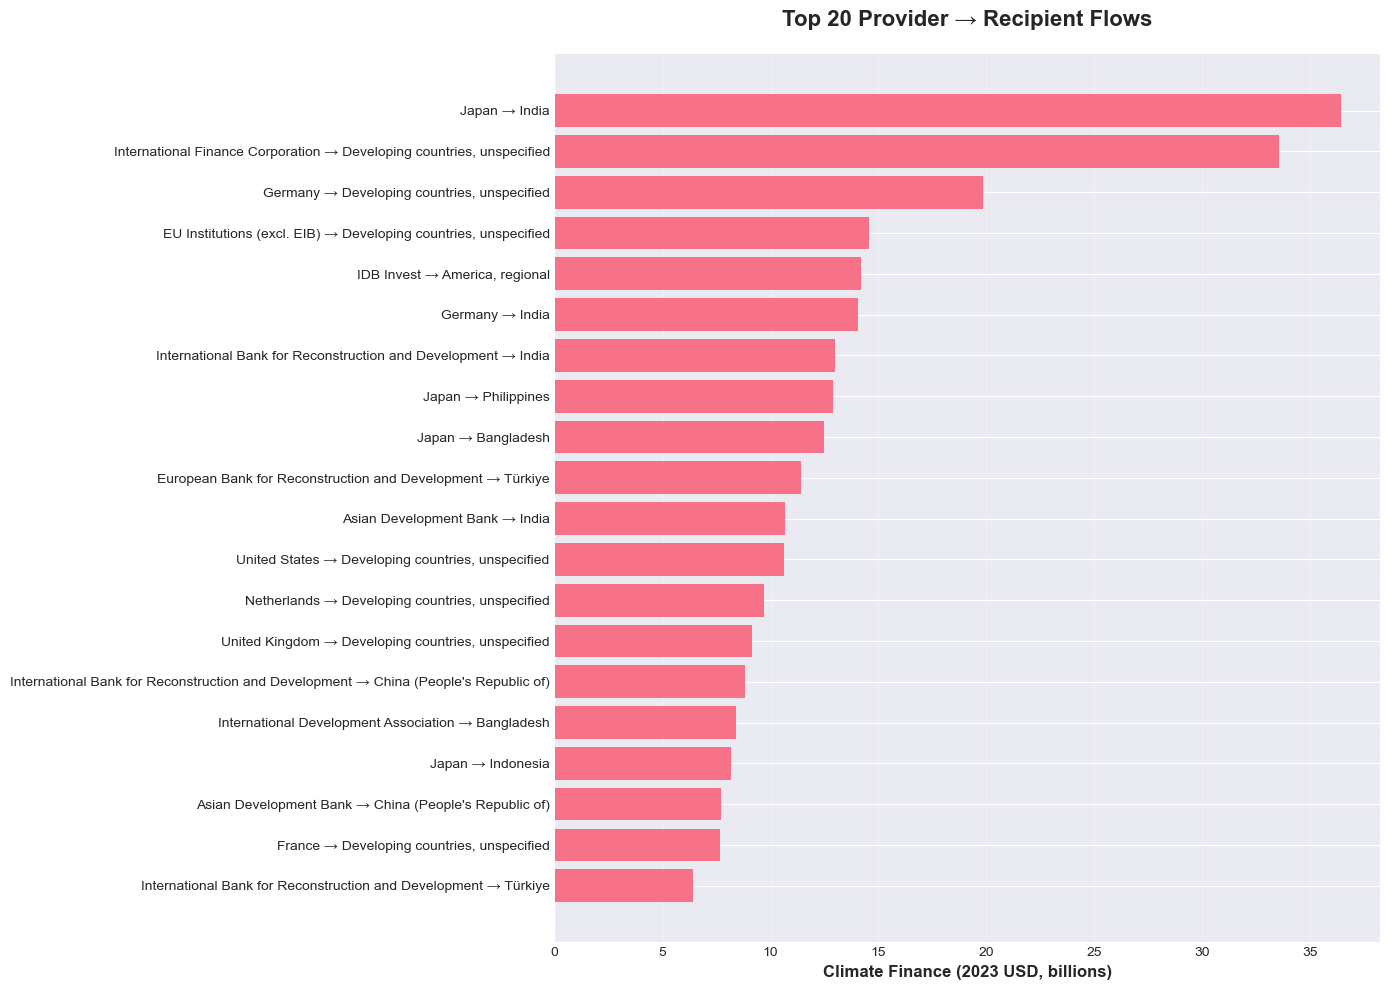

In [12]:
# For Sankey diagram, we'll use plotly if available, otherwise create a simplified version
try:
    import plotly.graph_objects as go
    
    # Get top providers and recipients
    if 'Provider (detailed)' in df.columns and 'Recipient' in df.columns:
        # Aggregate flows
        flows = df.groupby(['Provider (detailed)', 'Recipient'])[climate_finance_col].sum().reset_index()
        flows = flows[flows[climate_finance_col] > 0].sort_values(climate_finance_col, ascending=False).head(50)
        
        # Create node lists
        providers = flows['Provider (detailed)'].unique()
        recipients = flows['Recipient'].unique()
        
        all_nodes = list(providers) + list(recipients)
        node_indices = {node: i for i, node in enumerate(all_nodes)}
        
        # Create source, target, and value lists
        source = [node_indices[p] for p in flows['Provider (detailed)']]
        target = [node_indices[r] for r in flows['Recipient']]
        value = flows[climate_finance_col].tolist()
        
        # Create Sankey diagram
        fig = go.Figure(data=[go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=all_nodes
            ),
            link=dict(
                source=source,
                target=target,
                value=value
            )
        )])
        
        fig.update_layout(title_text="Provider → Recipient Climate Finance Flows", font_size=12, height=800)
        fig.show()
        
except ImportError:
    print("Plotly not available. Creating simplified flow visualization...")
    
    # Simplified version: Top provider-recipient pairs
    if 'Provider (detailed)' in df.columns and 'Recipient' in df.columns:
        flows = df.groupby(['Provider (detailed)', 'Recipient'])[climate_finance_col].sum().reset_index()
        top_flows = flows.nlargest(20, climate_finance_col)
        
        plt.figure(figsize=(14, 10))
        y_pos = np.arange(len(top_flows))
        plt.barh(y_pos, top_flows[climate_finance_col] / 1e6)
        plt.yticks(y_pos, [f"{p} → {r}" for p, r in zip(top_flows['Provider (detailed)'], top_flows['Recipient'])])
        plt.xlabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
        plt.title('Top 20 Provider → Recipient Flows', fontsize=16, fontweight='bold', pad=20)
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

## 8. Project-Level Impact Proxy

In [13]:
# A. Funding vs Climate Objective
if 'Climate objective (applies to Rio-marked data only or climate component)' in df.columns:
    climate_obj_data = df[df[climate_finance_col].notna() & df['Climate objective (applies to Rio-marked data only or climate component)'].notna()]
    
    plt.figure(figsize=(12, 8))
    objectives = climate_obj_data['Climate objective (applies to Rio-marked data only or climate component)'].unique()
    data_to_plot = [climate_obj_data[climate_obj_data['Climate objective (applies to Rio-marked data only or climate component)'] == obj][climate_finance_col].dropna() / 1e6 
                    for obj in objectives]
    
    bp = plt.boxplot(data_to_plot, labels=objectives, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightgreen')
        patch.set_alpha(0.7)
    
    plt.title('Funding vs Climate Objective', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Climate Objective', fontsize=12, fontweight='bold')
    plt.ylabel('Climate Finance (2023 USD, millions)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

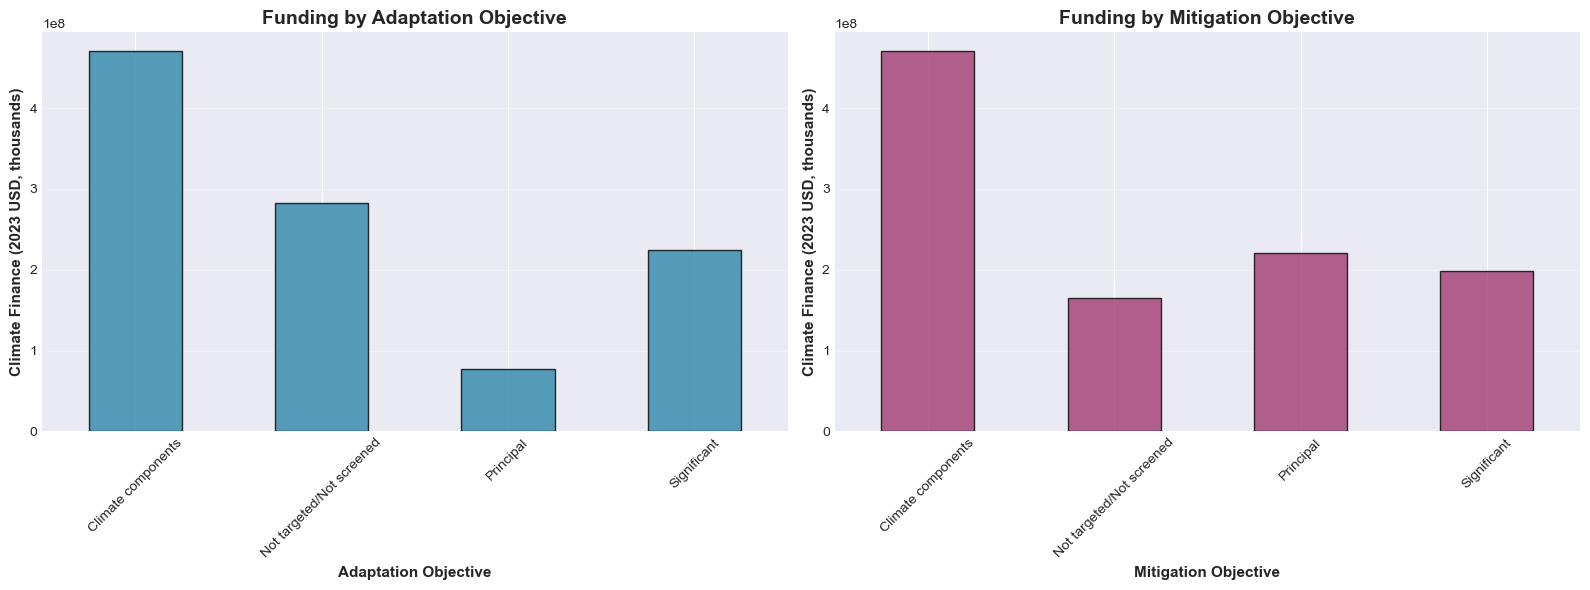

In [ ]:
# B. Funding vs Adaptation/Mitigation Marker
adaptation_obj_col = 'Adaptation objective (applies to Rio-marked data only)'
mitigation_obj_col = 'Mitigation objective (applies to Rio-marked data only)'

if adaptation_obj_col in df.columns and mitigation_obj_col in df.columns:
    # Create a combined analysis
    obj_data = df[df[climate_finance_col].notna()].copy()
    
    # Aggregate by adaptation and mitigation objectives
    adaptation_totals = obj_data.groupby(adaptation_obj_col)[climate_finance_col].sum()
    mitigation_totals = obj_data.groupby(mitigation_obj_col)[climate_finance_col].sum()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Adaptation objectives
    adaptation_totals.plot(kind='bar', ax=ax1, color='#2E86AB', alpha=0.8, edgecolor='black')
    ax1.set_title('Funding by Adaptation Objective', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Adaptation Objective', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Climate Finance (2023 USD, thousands)', fontsize=11, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Mitigation objectives
    mitigation_totals.plot(kind='bar', ax=ax2, color='#A23B72', alpha=0.8, edgecolor='black')
    ax2.set_title('Funding by Mitigation Objective', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Mitigation Objective', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Climate Finance (2023 USD, thousands)', fontsize=11, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. Channel of Delivery Analysis

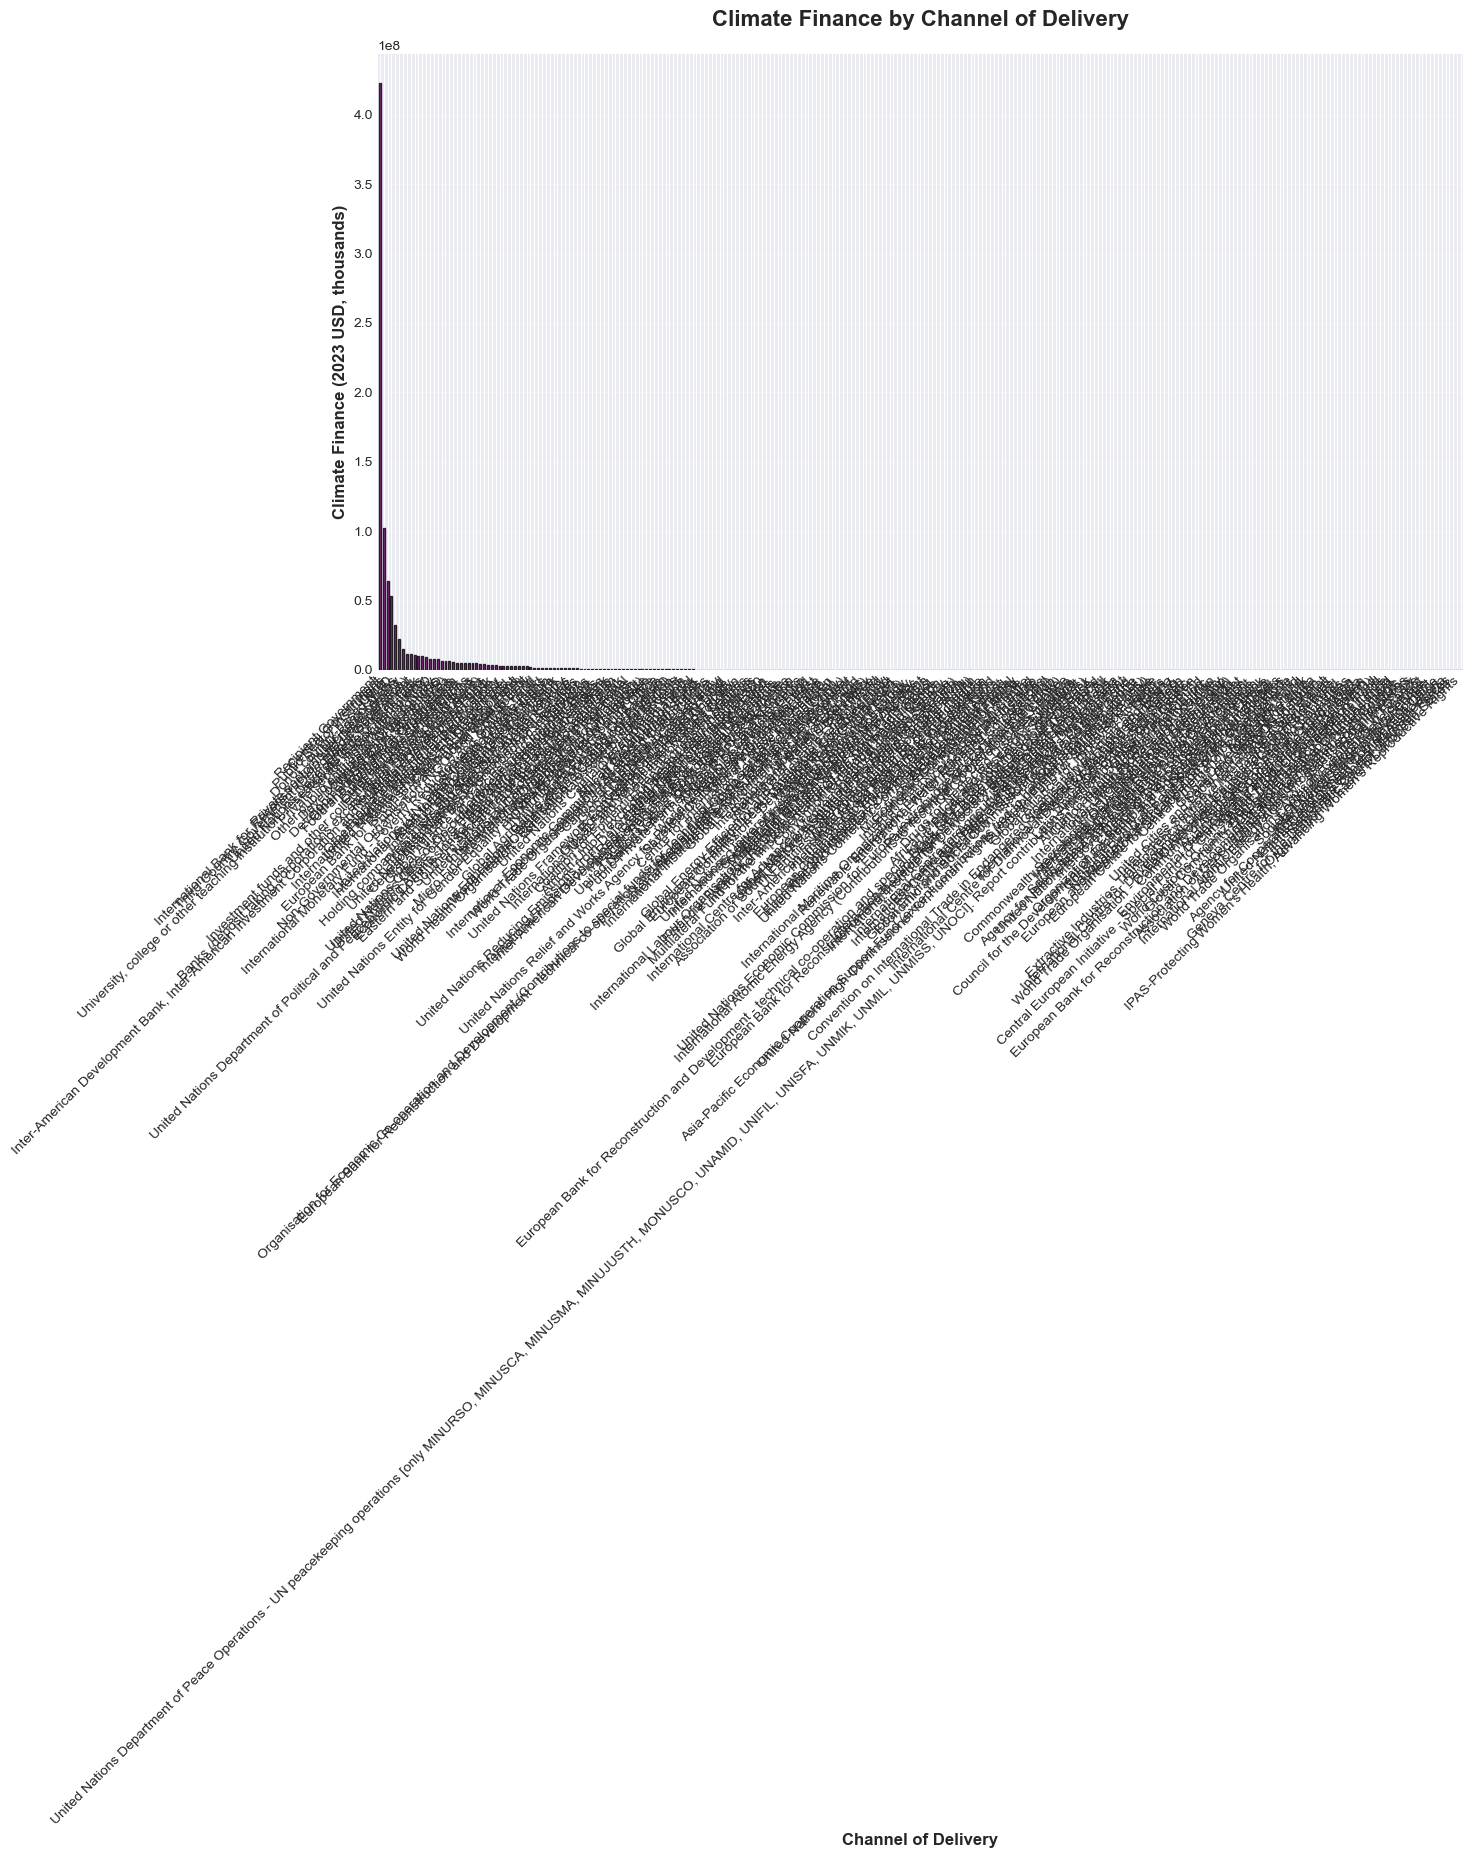


Finance by Channel of Delivery:
Channel of Delivery
Recipient Government                                                     422.77
Central Government                                                       102.15
Public Sector Institutions                                                64.31
Other                                                                     53.37
Donor country-based NGO                                                   31.99
                                                                          ...  
International Seed Testing Association                                     0.00
Secretaría General Iberoamericana                                          0.00
Geneva Centre for the Democratic Control of Armed Forces                   0.00
Organisation of Eastern Caribbean States                                   0.00
IPAS-Protecting Women’s Health, Advancing Women’s Reproductive Rights      0.00
Name: Climate-related development finance - Commitment - 2023 USD t

In [15]:
if 'Channel of Delivery' in df.columns:
    channel_finance = df.groupby('Channel of Delivery')[climate_finance_col].sum().sort_values(ascending=False)
    
    plt.figure(figsize=(14, 8))
    channel_finance.plot(kind='bar', color='purple', edgecolor='black', alpha=0.8)
    plt.title('Climate Finance by Channel of Delivery', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Channel of Delivery', fontsize=12, fontweight='bold')
    plt.ylabel('Climate Finance (2023 USD, thousands)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nFinance by Channel of Delivery:")
    print((channel_finance / 1e6).round(2))